# Error analysis

In [1]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib.colors import LogNorm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import xarray as xr
import rasterio as rio
import rioxarray
import pandas as pd

import deep_snow.models
import deep_snow.dataset
from deep_snow.utils import calc_norm, undo_norm, db_scale, calc_dowy
from deep_snow.dataset import norm_dict

## Make predictions

In [2]:
# path to test tiles
test_tile_dir = '/mnt/working/brencher/repos/deep-snow/data/test_tiles'
test_path_list = glob(f'{test_tile_dir}/ASO_50M_SD*.nc')

In [3]:
# path to model
model_path = '../../../weights/ResDepth_lr0.000457131171011064_weightdecay0.00010523970398286011_epochs62_mintestloss0.00091'

In [4]:
# open test data and calculate required variables
def prep_dataset(data_fn):
    ds = xr.open_dataset(data_fn)
    # radar data variables
    # convert to decibels
    ds['snowon_vv'] = (('y', 'x'), db_scale(ds['snowon_vv']))
    ds['snowon_vh'] =  (('y', 'x'),db_scale(ds['snowon_vh']))
    ds['snowoff_vv'] =  (('y', 'x'),db_scale(ds['snowoff_vv']))
    ds['snowoff_vh'] =  (('y', 'x'),db_scale(ds['snowoff_vh']))
    
    # calculate variables
    ds['snowon_cr'] = ds['snowon_vh'] - ds['snowon_vv']
    ds['snowoff_cr'] = ds['snowoff_vh'] - ds['snowoff_vv']
    ds['delta_cr'] = ds['snowon_cr'] - ds['snowoff_cr']

    ds['ndvi'] = (ds['B08'] - ds['B04'])/(ds['B08'] + ds['B04'])
    ds['ndsi'] = (ds['B03'] - ds['B11'])/(ds['B03'] + ds['B11'])
    ds['ndwi'] = (ds['B03'] - ds['B08'])/(ds['B03'] + ds['B08'])

    # dowy
    dowy_1d = calc_dowy(pd.to_datetime(data_fn.split('_')[5]).dayofyear)
    ds['dowy'] = (('y', 'x'), np.full_like(ds['latitude'], dowy_1d))

    return ds

In [5]:
# make predictions on the test data
def apply_model(ds, model, input_channels):
    ds = ds.fillna(0)
    ds['northness'] = np.cos(np.deg2rad(ds.aspect))

    data_dict = {}
    # normalize layers 
    data_dict['snodas_sd'] = calc_norm(torch.Tensor(ds['snodas_sd'].values), norm_dict['aso_sd'])
    data_dict['blue'] = calc_norm(torch.Tensor(ds['B02'].values), norm_dict['blue'])
    data_dict['swir1'] = calc_norm(torch.Tensor(ds['B11'].values), norm_dict['swir1'])
    data_dict['ndsi'] = calc_norm(torch.Tensor(ds['ndsi'].values), [-1, 1])
    data_dict['elevation'] = calc_norm(torch.Tensor(ds['elevation'].values), norm_dict['elevation'])
    data_dict['northness'] = calc_norm(torch.Tensor(ds['northness'].values), [0, 1])
    data_dict['slope'] = calc_norm(torch.Tensor(ds['slope'].values), norm_dict['slope'])
    data_dict['curvature'] = calc_norm(torch.Tensor(ds['curvature'].values), norm_dict['curvature'])
    data_dict['dowy'] = calc_norm(torch.Tensor(ds['dowy'].values), [0, 365])
    data_dict['delta_cr'] = calc_norm(torch.Tensor(ds['delta_cr'].values), norm_dict['delta_cr'])
    data_dict['fcf'] = calc_norm(torch.Tensor(ds['fcf'].values), [0, 1])

    # clamp values, add dimensions
    data_dict = {key: torch.clamp(data_dict[key], 0, 1)[None, None, :, :] for key in data_dict.keys()}
    inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1)

    # predict noise in tile
    with torch.no_grad():
        pred_sd = model(inputs.to('cuda'))
    pred_sd = pred_sd.detach().squeeze()
    
    # undo normalization
    pred_sd = undo_norm(pred_sd, deep_snow.dataset.norm_dict['aso_sd'])
    # add to xarray dataset
    ds['predicted_sd'] = (('y', 'x'), pred_sd.to('cpu').numpy())
    ds['predicted_sd'] = ds['predicted_sd'].where(ds['predicted_sd'] > 0, 0)
    
    return ds

In [6]:
 # define input channels for model
input_channels = ['snodas_sd',
                  'blue',
                  'swir1',
                  'ndsi',
                  'elevation',
                  'northness',
                  'slope',
                  'curvature',
                  'dowy',
                  'delta_cr',
                  'fcf'
                 ]

# load model 
model = deep_snow.models.ResDepth(n_input_channels=len(input_channels), depth=5)
model.load_state_dict(torch.load(model_path))
model.to('cuda');

/tmp/ipykernel_72042/3622324626.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [7]:
# select variables to examine uncertainty with
accuracy_list = ['aso_sd',
                 'predicted_sd',
                 'fcf',
                 'elevation',
                 'slope',
                 'aspect',
                 'dowy',
                 'snow_class',
                 'mtn_range']

In [11]:
# make predictions for all test data and load into a pandas dataframe
df = None

for i, tile_path in enumerate(test_path_list):
    ds = prep_dataset(tile_path)
    ds = ds.isel(x=slice(0, 640), y=slice(0, 640))
    ds = apply_model(ds, model, input_channels)
    ds['all_gaps'] = ds['aso_gap_map'] + ds['rtc_gap_map'] + ds['s2_gap_map']
    ds = ds.where(ds.all_gaps == 0, drop=True)
    # throw out if fewer than some number of valid pixels
    if ds.aso_sd.count() < 16384:
        continue
    tile_df = ds[accuracy_list].to_dataframe().reset_index()
    tile_df = tile_df.dropna(subset=['aso_sd'])
    tile_df = tile_df.drop(columns=['y', 'x', 'band', 'spatial_ref'])
    if df is None:
        df = tile_df
    else:
        df = pd.concat([df, tile_df], ignore_index=True)

## Analyze overall error

In [9]:
# # subsample data for fast plotting
# df = df.sample(100000)

In [12]:
# calculate error and absolute value error
df['error'] = df.aso_sd - df.predicted_sd
df['abs_error'] = df.error.abs()

In [13]:
# remove values where snow depth is 0
aso_sd_clean = df.aso_sd.where(df.aso_sd > 0).dropna()
predicted_sd_clean = df.predicted_sd.where(df.aso_sd > 0).dropna()

# Calculate metrics
r2 = r2_score(aso_sd_clean, predicted_sd_clean)
mse = mean_squared_error(aso_sd_clean, predicted_sd_clean)
mae = mean_absolute_error(aso_sd_clean, predicted_sd_clean)
pearson_r, _ = pearsonr(aso_sd_clean, predicted_sd_clean)

print(f'R²: {r2}')
print(f'pearson r: {pearson_r}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')

R²: 0.8688876628875732
pearson r: 0.9331569075584412
MSE: 0.3017885982990265
MAE: 0.35289669036865234


In [123]:
df['relative_error'] = ((df.predicted_sd.where(df.aso_sd > 0) - df.aso_sd.where(df.aso_sd > 0))/df.aso_sd.where(df.aso_sd > 0)).abs()*100
df['relative_error'] = df['relative_error'].where(df.predicted_sd > 0)

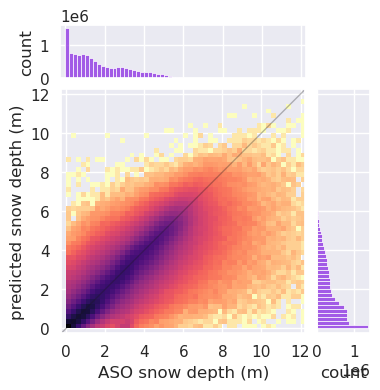

In [67]:
# plot predictions 
sns.set_theme()
axmin = -0.25
axmax = 12.25

# Create a grid layout
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(5, 5, hspace=0.2, wspace=0.2)
ax_main = fig.add_subplot(gs[1:5, 0:4])
ax_histx = fig.add_subplot(gs[0, 0:4])
ax_histy = fig.add_subplot(gs[1:5, 4])

# Main plot
sns.histplot(ax=ax_main, x=df.aso_sd.where(df.aso_sd > 0), y=df.predicted_sd.where(df.aso_sd > 0),
             cmap='magma_r', cbar=False, alpha=1, binwidth=0.25, vmin=None, vmax=None, norm=LogNorm())
ax_main.plot([-15, 30], [-15, 30], color='k', linestyle='-', linewidth=1, alpha=0.3)
ax_main.set_xlabel('ASO snow depth (m)')
ax_main.set_ylabel('predicted snow depth (m)')
ax_main.set_box_aspect(1)
ax_main.set_xlim(axmin, axmax)
ax_main.set_ylim(axmin, axmax)
ax_main.set_xticks([0, 2, 4, 6, 8, 10, 12])
ax_main.set_yticks([0, 2, 4, 6, 8, 10, 12])

ax_main.tick_params(axis='x', pad=2)
ax_main.tick_params(axis='y', pad=2)

# Histogram for x-axis (ASO snow depth)
sns.histplot(ax=ax_histx, x=df.aso_sd[df.aso_sd > 0], binwidth=0.2, color='blueviolet', edgecolor='white', linewidth=0.5)
ax_histx.set_ylabel('count')
ax_histx.set_xlabel('')
ax_histx.set_xticklabels([])
ax_histx.set_xlim(axmin, axmax)
ax_histx.set_xticks([0, 2, 4, 6, 8, 10, 12])
ax_histx.tick_params(axis='x', pad=2)
ax_histx.tick_params(axis='y', pad=2)

# Histogram for y-axis (predicted snow depth)
sns.histplot(ax=ax_histy, y=df.predicted_sd[df.aso_sd > 0], binwidth=0.2, color='blueviolet', edgecolor='white', linewidth=0.5)
ax_histy.set_xlabel('count')
ax_histy.set_ylabel('')
ax_histy.set_ylim(axmin, axmax)
ax_histy.set_yticks([0, 2, 4, 6, 8, 10, 12])
ax_histy.set_yticklabels([])

ax_histy.tick_params(axis='x', pad=2)
ax_histy.tick_params(axis='y', pad=2)

#fig.tight_layout()

#fig.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_2dhist_wcbar.png', dpi=400, bbox_inches='tight')

In [16]:
# accuracy where snow depth is 0
sd_0_mse = mean_squared_error(df.aso_sd[df.aso_sd == 0], df.predicted_sd[df.aso_sd == 0])
sd_0_mae = mean_absolute_error(df.aso_sd[df.aso_sd == 0], df.predicted_sd[df.aso_sd == 0])

print(f'MSE: {sd_0_mse}')
print(f'MAE: {sd_0_mae}')

MSE: 0.015775151550769806
MAE: 0.04616778343915939


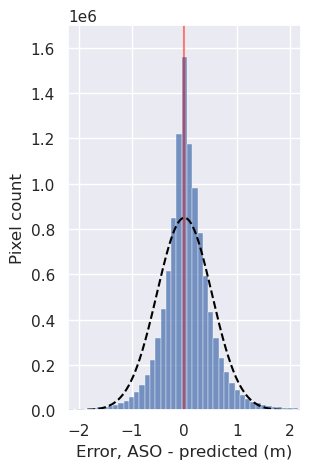

In [346]:
# plot distribution of errors
sns.set_theme()

# Generate x values and corresponding normal PDF values scaled to match the histogram's area
x = np.linspace(-4, 4, 1000)
pdf = norm.pdf(x, loc=0, scale=np.std(df.error))

# Scale the PDF to match the histogram count scale
bin_width = 0.1
pdf_scaled = pdf * len(df.error) * bin_width

f, ax = plt.subplots(figsize=(3, 5))
sns.histplot(df.error[df.aso_sd > 0], ax=ax, bins=np.arange(-3, 3, 0.1)-0.05)
ax.plot(x, pdf_scaled, color='black', linestyle='--', label='Normal PDF')
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(0, 1.7*1e6)
ax.set_xlabel('Error, ASO - predicted (m)')
ax.set_ylabel('Pixel count')
ax.axvline(0, c='red', alpha=0.5)
ax.set_xticks([-2, -1, 0, 1, 2])

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_errorhist_w_normal.png', dpi=400, bbox_inches='tight')

In [127]:
def nmad(a, c=1.4826):
    return np.median(np.fabs(a - np.median(a))) * c

In [361]:
print(f'mean: {df.error[df.aso_sd > 0].mean()}')
print(f'standard deviation: {df.error[df.aso_sd > 0].std()}')
print(f'skewness: {df.error[df.aso_sd > 0].skew()}')
print(f'kurtosis: {df.error[df.aso_sd > 0].kurtosis()}')

mean: 0.057575877755880356
standard deviation: 0.5198643803596497
skewness: 0.6161126494407654
kurtosis: 9.36752986907959


In [362]:
print(f'mean: {df.standardized_error[df.aso_sd > 0].mean()}')
print(f'standard deviation: {df.standardized_error[df.aso_sd > 0].std()}')
print(f'skewness: {df.standardized_error[df.aso_sd > 0].skew()}')
print(f'kurtosis: {df.standardized_error[df.aso_sd > 0].kurtosis()}')

mean: 0.164943991334683
standard deviation: 1.1549545009659907
skewness: 0.5107837437525569
kurtosis: 3.7291364393879842


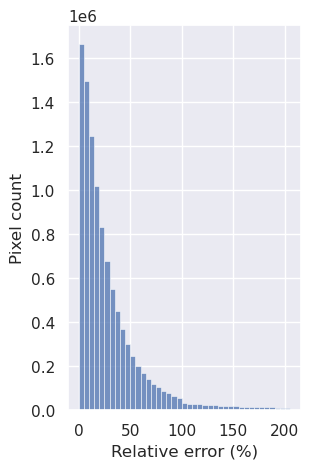

In [130]:
f, ax = plt.subplots(figsize=(3, 5))
sns.histplot(df.relative_error.where(df.relative_error < 100000), ax=ax, bins=np.arange(0, 210, 5))
ax.set_xlabel('Relative error (%)')
ax.set_ylabel('Pixel count')

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_relativeerrorhist.png', dpi=400, bbox_inches='tight')

In [125]:
df.relative_error.median()

20.598272

In [129]:
nmad(df.relative_error[df.relative_error > -1])

21.683389790725705

In [113]:
df.iloc[df.relative_error.idxmax()]

aso_sd                                 0.086078
predicted_sd                           7.662422
fcf                                         0.0
elevation                           3071.331787
slope                                 17.998104
aspect                                 307.4584
dowy                                      208.0
snow_class                                  5.0
mtn_range                               11928.0
time                 2023-05-01 14:00:08.426977
error                                 -7.576344
abs_error                              7.576344
relative_error                      8801.748047
predicted_sd_bins               (3.903, 13.027]
bin_center                             3060.967
slope_bins                      (17.498, 21.29]
fcf_bins                          (-0.001, 0.1]
aspect_bins                      (288.0, 324.0]
elevation_bins             (2967.578, 3154.356]
month                                         5
year                                    

In [62]:
bins

0             (1.551, 1.882]
1             (1.551, 1.882]
2             (1.551, 1.882]
3             (1.551, 1.882]
4             (1.882, 2.304]
                  ...       
14338009    (-0.001, 0.0137]
14338010    (-0.001, 0.0137]
14338011    (-0.001, 0.0137]
14338012    (-0.001, 0.0137]
14338013    (-0.001, 0.0137]
Name: aso_sd, Length: 14338014, dtype: category
Categories (16, interval[float64, right]): [(-0.001, 0.0137] < (0.0137, 0.115] < (0.115, 0.29] < (0.29, 0.483] ... (2.749, 3.188] < (3.188, 3.75] < (3.75, 4.508] < (4.508, 21.605]]

In [59]:
from scipy.interpolate import interp1d

In [60]:
# estimate bias with snow depth
bins = pd.qcut(df['aso_sd'], q=20, duplicates='drop')

# calculate central tendency of error (median) and cound for each bin
uncorrected_grouped = df.groupby(bins).agg({'error': ['median', 'count']}).reset_index()
uncorrected_grouped.columns = ['aso_sd_bin', 'bias_uncorrected', 'count']
# Calculate bin centers 
uncorrected_grouped['bin_center'] = uncorrected_grouped['aso_sd_bin'].apply(lambda x: x.mid)

uncorrected_interpolator = interp1d(uncorrected_grouped['bin_center'],
                        uncorrected_grouped['bias_uncorrected'],
                        kind='linear',
                        fill_value='extrapolate')
uncorrected_even_intervals = np.arange(df['aso_sd'].min(), df['aso_sd'].max(), 0.01)
if df['aso_sd'].max() not in uncorrected_even_intervals:
    uncorrected_even_intervals = np.append(uncorrected_even_intervals, df['aso_sd'].max())

uncorrected_interpolated_bias = uncorrected_interpolator(uncorrected_even_intervals)

/tmp/ipykernel_72042/2024919833.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  uncorrected_grouped = df.groupby(bins).agg({'error': ['median', 'count']}).reset_index()


(-0.1, 0.4)

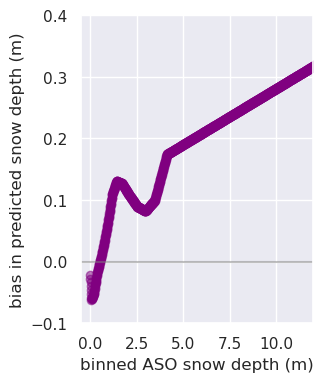

In [64]:
sns.set_theme()
# plot bias for each snow depth bin
f, ax = plt.subplots(figsize=(3, 4))
ax.axhline(0, c='gray', alpha=0.5)
scatter = ax.scatter(uncorrected_even_intervals,
                  uncorrected_interpolated_bias,
                     #c=np.log(grouped['count'][grouped['count'] >= 1000]), 
                     c='purple', alpha=0.5, )
#f.colorbar(scatter, label='log(count)')
ax.set_xlabel('binned ASO snow depth (m)')
ax.set_ylabel('bias in predicted snow depth (m)')
ax.set_xlim(-0.5, 12)
ax.set_ylim(-0.1, 0.4)

#ax.set_aspect('equal')
#ax.set_aspect('equal')

#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_sd_bias.png', dpi=400, bbox_inches='tight')

In [37]:
df['bias_uncorrected'] = np.interp(df['aso_sd'], uncorrected_even_intervals, uncorrected_interpolated_bias)
# Remove systematic error from error
df['error_debiased'] = df['error'] - df['bias_uncorrected']

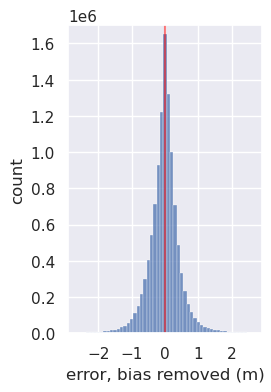

In [38]:
sns.set_theme()
# plot distribution of error with bias removed 
f, ax = plt.subplots(figsize=(2.5, 4))
sns.histplot(df.error_debiased[df.aso_sd > 0], ax=ax, bins=np.arange(-3, 3, 0.1)-0.05)
ax.set_xlim(-2.9, 2.9)
ax.set_ylim(0, 1.7*1e6)
ax.set_xlabel('error, bias removed (m)')
ax.set_ylabel('count')
ax.axvline(0, c='red', alpha=0.5)
ax.set_xticks([-2, -1, 0, 1, 2])

#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_errorhist_bias_removed.png', dpi=400, bbox_inches='tight')

In [39]:
print(f'median: {df.error_debiased[df.aso_sd > 0].median()}')
print(f'nmad: {nmad(df.error_debiased[df.aso_sd > 0])}')
print(f'skewness: {df.error_debiased[df.aso_sd > 0].skew()}')
print(f'kurtosis: {df.error_debiased[df.aso_sd > 0].kurtosis()}')

median: -0.002791936527265979


NameError: name 'nmad' is not defined

## identify and correct systematic error

In [286]:
# estimate bias with snow depth
bins = pd.qcut(df['aspect'], q=10, duplicates='drop')
# calculate central tendency of error (median) and cound for each bin
predicted_grouped = df.groupby(bins).agg({'error': ['median', 'count']}).reset_index()
predicted_grouped.columns = ['aspect_bin', 'bias_predicted', 'count']
# Calculate bin centers 
predicted_grouped['bin_center'] = predicted_grouped['aspect_bin'].apply(lambda x: x.mid)

predicted_interpolator = interp1d(predicted_grouped['bin_center'],
                        predicted_grouped['bias_predicted'],
                        kind='linear',
                        fill_value='extrapolate')
predicted_even_intervals = np.arange(df['aspect'].min(), df['aspect'].max(), 1)
if df['aspect'].max() not in predicted_even_intervals:
    predicted_even_intervals = np.append(predicted_even_intervals, df['aspect'].max())

predicted_interpolated_bias = predicted_interpolator(predicted_even_intervals)

/tmp/ipykernel_72042/3089309225.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_grouped = df.groupby(bins).agg({'error': ['median', 'count']}).reset_index()


Text(0, 0.5, 'bias in predicted snow depth (m)')

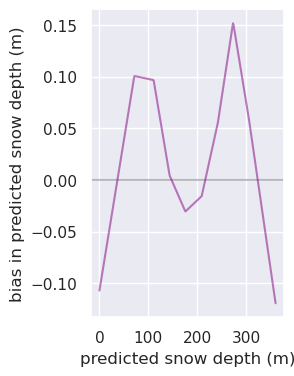

In [288]:
# plot bias for each snow depth bin
f, ax = plt.subplots(figsize=(2.5, 4))
ax.axhline(0, c='gray', alpha=0.5)
scatter = ax.plot(predicted_even_intervals,
                  predicted_interpolated_bias,
                     #c=np.log(grouped['count'][grouped['count'] >= 1000]), 
                     c='purple', alpha=0.5, )
#f.colorbar(scatter, label='log(count)')
ax.set_xlabel('predicted snow depth (m)')
ax.set_ylabel('bias in predicted snow depth (m)')
# ax.set_xlim(-0.2, 8)
# ax.set_ylim(-0.15, 0.8)
# ax.set_xticks([0, 2, 4, 6, 8])

#ax.set_aspect('equal')
#ax.set_aspect('equal')

#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_sd_predicted_bias.png', dpi=400, bbox_inches='tight')

In [289]:
df['bias_predicted'] = np.interp(df['aspect'], predicted_even_intervals, predicted_interpolated_bias)

# remove systematic error from error
df['predicted_sd_corrected'] = df['predicted_sd'] + df['bias_predicted']
df['error_corrected'] = df['aso_sd'] - df['predicted_sd_corrected']

In [290]:
# remove values where snow depth is 0
aso_sd_clean = df.aso_sd.where(df.aso_sd > 0).dropna()
predicted_sd_clean = df.predicted_sd_corrected.where(df.aso_sd > 0).dropna()

# Calculate metrics
r2 = r2_score(aso_sd_clean, predicted_sd_clean)
mse = mean_squared_error(aso_sd_clean, predicted_sd_clean)
mae = mean_absolute_error(aso_sd_clean, predicted_sd_clean)
pearson_r, _ = pearsonr(aso_sd_clean, predicted_sd_clean)

print(f'R²: {r2}')
print(f'pearson r: {pearson_r}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')

R²: 0.8826705316002517
pearson r: 0.9397562965929828
MSE: 0.26761956575431883
MAE: 0.3420123672855181


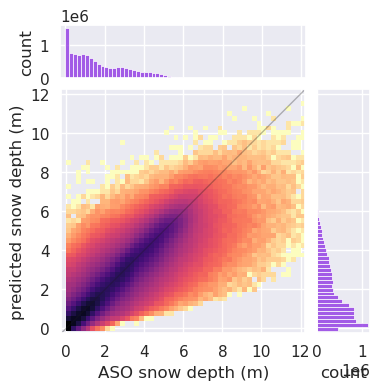

In [291]:
# plot predictions 
sns.set_theme()
axmin = -0.25
axmax = 12.25

# Create a grid layout
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(5, 5, hspace=0.2, wspace=0.2)
ax_main = fig.add_subplot(gs[1:5, 0:4])
ax_histx = fig.add_subplot(gs[0, 0:4])
ax_histy = fig.add_subplot(gs[1:5, 4])

# Main plot
sns.histplot(ax=ax_main, x=df.aso_sd[df.aso_sd > 0], y=df.predicted_sd_corrected[df.aso_sd > 0],
             cmap='magma_r', cbar=False, alpha=1, binwidth=0.25, vmin=None, vmax=None, norm=LogNorm())
ax_main.plot([-15, 30], [-15, 30], color='k', linestyle='-', linewidth=1, alpha=0.3)
ax_main.set_xlabel('ASO snow depth (m)')
ax_main.set_ylabel('predicted snow depth (m)')
ax_main.set_box_aspect(1)
ax_main.set_xlim(axmin, axmax)
ax_main.set_ylim(axmin, axmax)
ax_main.set_xticks([0, 2, 4, 6, 8, 10, 12])
ax_main.set_yticks([0, 2, 4, 6, 8, 10, 12])

ax_main.tick_params(axis='x', pad=2)
ax_main.tick_params(axis='y', pad=2)

# Histogram for x-axis (ASO snow depth)
sns.histplot(ax=ax_histx, x=df.aso_sd[df.aso_sd > 0], binwidth=0.2, color='blueviolet', edgecolor='white', linewidth=0.5)
ax_histx.set_ylabel('count')
ax_histx.set_xlabel('')
ax_histx.set_xticklabels([])
ax_histx.set_xlim(axmin, axmax)
ax_histx.set_xticks([0, 2, 4, 6, 8, 10, 12])
ax_histx.tick_params(axis='x', pad=2)
ax_histx.tick_params(axis='y', pad=2)

# Histogram for y-axis (predicted snow depth)
sns.histplot(ax=ax_histy, y=df.predicted_sd_corrected[df.aso_sd > 0], binwidth=0.2, color='blueviolet', edgecolor='white', linewidth=0.5)
ax_histy.set_xlabel('count')
ax_histy.set_ylabel('')
ax_histy.set_ylim(axmin, axmax)
ax_histy.set_yticks([0, 2, 4, 6, 8, 10, 12])
ax_histy.set_yticklabels([])

ax_histy.tick_params(axis='x', pad=2)
ax_histy.tick_params(axis='y', pad=2)

#fig.tight_layout()

#fig.savefig('../../../figs/quinn_ResDepthv10_256epochs_2dhist_corrected.png', dpi=400, bbox_inches='tight')

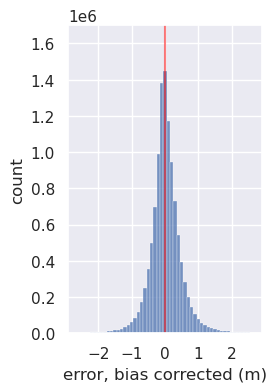

In [292]:
# plot distribution of error with bias removed 
f, ax = plt.subplots(figsize=(2.5, 4))
sns.histplot(df.error_corrected[df.aso_sd > 0], ax=ax, bins=np.arange(-3, 3, 0.1)-0.05)
ax.set_xlim(-2.9, 2.9)
ax.set_ylim(0, 1.7*1e6)
ax.set_xlabel('error, bias corrected (m)')
ax.set_ylabel('count')
ax.axvline(0, c='red', alpha=0.5)
ax.set_xticks([-2, -1, 0, 1, 2])

#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_errorhist_bias_removed.png', dpi=400, bbox_inches='tight')

In [295]:
print(f'median: {df.error_corrected[df.aso_sd > 0].mean()}')
print(f'std: {df.error_corrected[df.aso_sd > 0].std()}')
print(f'skewness: {df.error_corrected[df.aso_sd > 0].skew()}')
print(f'kurtosis: {df.error_corrected[df.aso_sd > 0].kurtosis()}')

median: 0.026344575500141045
std: 0.5166483842776776
skewness: 0.747636047438277
kurtosis: 10.674783065372322


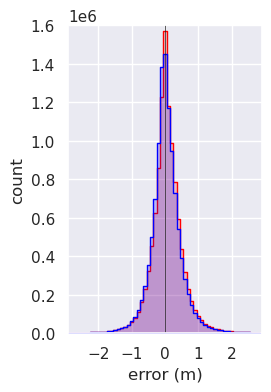

In [296]:
# plot error distributions for fig
f, ax = plt.subplots(figsize=(2.5, 4))
sns.histplot(df.error[df.aso_sd > 0], ax=ax, bins=np.arange(-3, 3, 0.1)-0.05, alpha=0.2, color='Red', element="step")
sns.histplot(df.error_corrected[df.aso_sd > 0], ax=ax, bins=np.arange(-3, 3, 0.1)-0.05, alpha=0.2, color='Blue', element="step")
ax.set_xlim(-2.9, 2.9)
ax.set_ylim(0, 1.6*1e6)
ax.set_xlabel('error (m)')
ax.set_ylabel('count')
ax.axvline(0, c='k', alpha=1, linewidth=0.5)
ax.set_xticks([-2, -1, 0, 1, 2])

#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_errorhist.png', dpi=400, bbox_inches='tight')

## measure remaining systematic error

In [297]:
# estimate bias with snow depth
bin_width=0.5
bins = pd.qcut(df['aso_sd'], q=20, duplicates='drop')
# calculate central tendency of error (median) and cound for each bin
corrected_grouped = df.groupby(bins).agg({'error_corrected': ['median', 'count']}).reset_index()
corrected_grouped.columns = ['aso_sd_bin', 'bias_remaining', 'count']
# Calculate bin centers 
corrected_grouped['bin_center'] = corrected_grouped['aso_sd_bin'].apply(lambda x: x.mid)

corrected_interpolator = interp1d(corrected_grouped['bin_center'],
                        corrected_grouped['bias_remaining'],
                        kind='linear',
                        fill_value='extrapolate')
corrected_even_intervals = np.arange(df['aso_sd'].min(), df['aso_sd'].max(), 0.01)
if df['aso_sd'].max() not in corrected_even_intervals:
    corrected_even_intervals = np.append(corrected_even_intervals, df['aso_sd'].max())

corrected_interpolated_bias = corrected_interpolator(corrected_even_intervals)

/tmp/ipykernel_72042/4221512936.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  corrected_grouped = df.groupby(bins).agg({'error_corrected': ['median', 'count']}).reset_index()


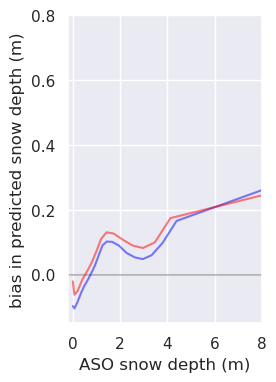

In [298]:
# plot bias for each snow depth bin
f, ax = plt.subplots(figsize=(2.5, 4))
ax.axhline(0, c='gray', alpha=0.5)
ax.plot(corrected_even_intervals,
        corrected_interpolated_bias,
        c='blue', alpha=0.5)
ax.plot(uncorrected_even_intervals,
        uncorrected_interpolated_bias,
        c='red', alpha=0.5)
#f.colorbar(scatter, label='log(count)')
ax.set_xlabel('ASO snow depth (m)')
ax.set_ylabel('bias in predicted snow depth (m)')
ax.set_xlim(-0.2, 8)
ax.set_ylim(-0.15, 0.8)
ax.set_xticks([0, 2, 4, 6, 8])

#ax.set_aspect('equal')
#ax.set_aspect('equal')

#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_sd_bias.png', dpi=400, bbox_inches='tight')

In [40]:
df['bias_remaining'] = np.interp(df['aso_sd'], corrected_even_intervals, corrected_interpolated_bias)

# Random error

In [68]:
# remove pixels with snow depths of 0
df = df[df['aso_sd'] > 0]

## snow depth

/tmp/ipykernel_72042/1918300762.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_values = df.groupby('predicted_sd_bins')['error'].std().reset_index()
/tmp/ipykernel_72042/1918300762.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


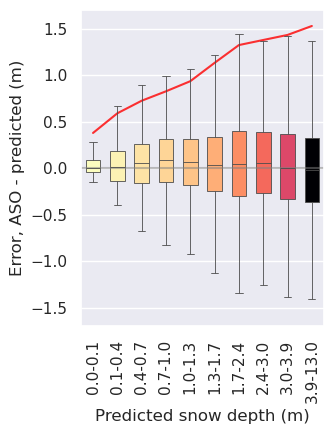

In [143]:
sns.set_theme()
from matplotlib.cm import ScalarMappable

# predicted snow depth
df['predicted_sd_bins'] = pd.qcut(df['predicted_sd'], q=10, duplicates='drop')
df['bin_center'] = df['predicted_sd_bins'].apply(lambda x: (x.left + x.right) / 2)

std_values = df.groupby('predicted_sd_bins')['error'].std().reset_index()
std_values['bin_center'] = std_values['predicted_sd_bins'].apply(lambda x: (x.left + x.right) / 2)

f, ax = plt.subplots(1, 1, figsize=(3.5, 4.5))
sns.lineplot(std_values['error']*2, ax=ax, c='red', alpha=0.8)
boxplot = sns.boxplot(x=df.predicted_sd_bins,
            y=df.error,
            ax=ax, showfliers=False,
           linewidth=0.6, width=0.6, patch_artist=True)
ax.axhline(0, c='Gray', alpha=0.5)

# violinplot = sns.violinplot(x=df.predicted_sd_bins,
#             y=df.error,
#             ax=ax,
#            linewidth=0, width=1.5)

# Calculate the center values of each bin
center_values = [(interval.left + interval.right) / 2 for interval in df.predicted_sd_bins.cat.categories]

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(min(center_values), max(center_values))
colors = plt.cm.magma_r(norm(center_values))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax.tick_params(axis='x', rotation=90)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.predicted_sd_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
ax.set_ylabel('Error, ASO - predicted (m)')
ax.set_xlabel('Predicted snow depth (m)')
ax.set_ylim(-1.7, 1.7)

# # Add colorbar
# sm = ScalarMappable(cmap='magma_r', norm=norm)
# sm.set_array([])
# cbar = f.colorbar(sm, ax=ax)
# cbar.set_label('snow depth (m)', rotation=270, labelpad=15)

plt.tight_layout()

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_predicted_sd_randomerror.png', dpi=400, bbox_inches='tight')

## slope

/tmp/ipykernel_72042/883371356.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_values = df.groupby('slope_bins')['error'].std().reset_index()
/tmp/ipykernel_72042/883371356.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


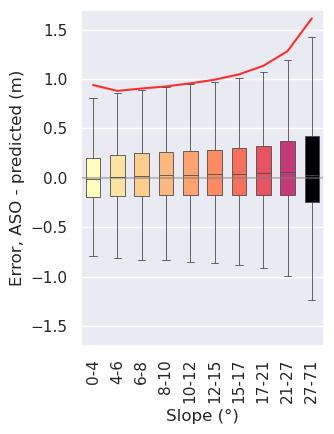

In [146]:
# slope
df['slope_bins'] = pd.qcut(df['slope'], q=10, duplicates='drop')
df['bin_center'] = df['slope_bins'].apply(lambda x: (x.left + x.right) / 2)

std_values = df.groupby('slope_bins')['error'].std().reset_index()
std_values['bin_center'] = std_values['slope_bins'].apply(lambda x: (x.left + x.right) / 2)

f, ax = plt.subplots(1, 1, figsize=(3.5, 4.5))
sns.lineplot(std_values['error']*2, ax=ax, c='red', alpha=0.8)
boxplot = sns.boxplot(x=df.slope_bins,
            y=df.error,
            ax=ax, showfliers=False,
           linewidth=0.6, width=0.6, patch_artist=True)
ax.axhline(0, c='Gray', alpha=0.5)

# Calculate the center values of each bin
center_values = [(interval.left + interval.right) / 2 for interval in df.slope_bins.cat.categories]

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(min(center_values), max(center_values))
colors = plt.cm.magma_r(norm(center_values))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax.tick_params(axis='x', rotation=90)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.0f}-{interval.right:.0f}" for interval in df.slope_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
ax.set_ylabel('Error, ASO - predicted (m)')
ax.set_xlabel('Slope (\N{DEGREE SIGN})')
ax.set_ylim(-1.7, 1.7)

# # Add colorbar
# sm = ScalarMappable(cmap='magma_r', norm=norm)
# sm.set_array([])
# cbar = f.colorbar(sm, ax=ax)
# cbar.set_label('slope (\N{DEGREE SIGN})', rotation=270, labelpad=15)

plt.tight_layout()
f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_slope_randomerror.png', dpi=400, bbox_inches='tight')

## FCF

/tmp/ipykernel_72042/46188761.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_values = df.groupby('fcf_bins')['error'].std().reset_index()
/tmp/ipykernel_72042/46188761.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


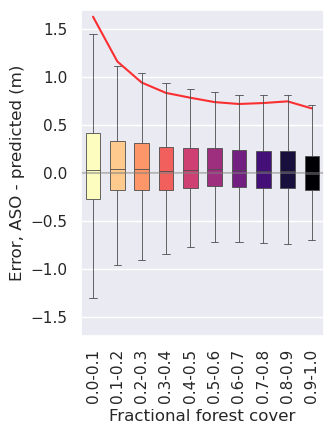

In [193]:
# fcf
df['fcf_bins'] = pd.cut(df['fcf'], bins=10, duplicates='drop')
df['bin_center'] = df['fcf_bins'].apply(lambda x: (x.left + x.right) / 2)

std_values = df.groupby('fcf_bins')['error'].std().reset_index()
std_values['bin_center'] = std_values['fcf_bins'].apply(lambda x: (x.left + x.right) / 2)

f, ax = plt.subplots(1, 1, figsize=(3.5, 4.5))
sns.lineplot(std_values['error']*2, ax=ax, c='red', alpha=0.8)
boxplot = sns.boxplot(x=df.fcf_bins,
            y=df.error,
            ax=ax, showfliers=False,
           linewidth=0.6, width=0.6, patch_artist=True)
ax.axhline(0, c='Gray', alpha=0.5)

# Calculate the center values of each bin
center_values = [(interval.left + interval.right) / 2 for interval in df.fcf_bins.cat.categories]

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(min(center_values), max(center_values))
colors = plt.cm.magma_r(norm(center_values))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax.tick_params(axis='x', rotation=90)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.fcf_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
ax.set_ylabel('Error, ASO - predicted (m)')
ax.set_xlabel('Fractional forest cover')

# Add colorbar
# sm = ScalarMappable(cmap='magma_r', norm=norm)
# sm.set_array([])
# cbar = f.colorbar(sm, ax=ax)
# cbar.set_label('Fractional forest cover', rotation=270, labelpad=25)
ax.set_ylim(-1.7, 1.7)

plt.tight_layout()

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_fcf_randomerror.png', dpi=400, bbox_inches='tight')

/tmp/ipykernel_72042/230851300.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_values = df.groupby('fcf_bins')['standardized_error'].std().reset_index()
/tmp/ipykernel_72042/230851300.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


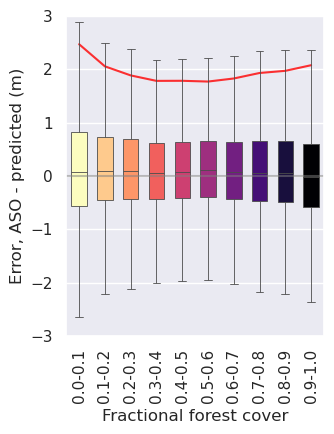

In [310]:
# fcf
df['fcf_bins'] = pd.cut(df['fcf'], bins=10, duplicates='drop')
df['bin_center'] = df['fcf_bins'].apply(lambda x: (x.left + x.right) / 2)

std_values = df.groupby('fcf_bins')['standardized_error'].std().reset_index()
std_values['bin_center'] = std_values['fcf_bins'].apply(lambda x: (x.left + x.right) / 2)

f, ax = plt.subplots(1, 1, figsize=(3.5, 4.5))
sns.lineplot(std_values['standardized_error']*2, ax=ax, c='red', alpha=0.8)
boxplot = sns.boxplot(x=df.fcf_bins,
            y=df.standardized_error,
            ax=ax, showfliers=False,
           linewidth=0.6, width=0.6, patch_artist=True)
ax.axhline(0, c='Gray', alpha=0.5)

# Calculate the center values of each bin
center_values = [(interval.left + interval.right) / 2 for interval in df.fcf_bins.cat.categories]

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(min(center_values), max(center_values))
colors = plt.cm.magma_r(norm(center_values))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax.tick_params(axis='x', rotation=90)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.fcf_bins.cat.categories]
ax.set_xticklabels(new_labels)
#ax.set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
ax.set_ylabel('Error, ASO - predicted (m)')
ax.set_xlabel('Fractional forest cover')

# Add colorbar
# sm = ScalarMappable(cmap='magma_r', norm=norm)
# sm.set_array([])
# cbar = f.colorbar(sm, ax=ax)
# cbar.set_label('Fractional forest cover', rotation=270, labelpad=25)
ax.set_ylim(-3, 3)

plt.tight_layout()

#f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_fcf_randomerror.png', dpi=400, bbox_inches='tight')

## Aspect

/tmp/ipykernel_72042/4257228036.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_values = df.groupby('aspect_bins')['error'].std().reset_index()
/tmp/ipykernel_72042/4257228036.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


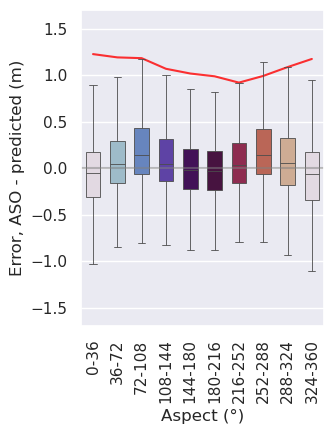

In [194]:
# aspect
df['aspect_bins'] = pd.cut(df['aspect'], bins=10, duplicates='drop')
df['bin_center'] = df['aspect_bins'].apply(lambda x: (x.left + x.right) / 2)

std_values = df.groupby('aspect_bins')['error'].std().reset_index()
std_values['bin_center'] = std_values['aspect_bins'].apply(lambda x: (x.left + x.right) / 2)

f, ax = plt.subplots(1, 1, figsize=(3.5, 4.5))
sns.lineplot(std_values['error']*2, ax=ax, c='red', alpha=0.8)
boxplot = sns.boxplot(x=df.aspect_bins,
            y=df.error,
            ax=ax, showfliers=False,
           linewidth=0.6, width=0.6, patch_artist=True)
ax.axhline(0, c='Gray', alpha=0.5)

# Calculate the center values of each bin
center_values = [(interval.left + interval.right) / 2 for interval in df.aspect_bins.cat.categories]

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(min(center_values), max(center_values))
colors = plt.cm.twilight(norm(center_values))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax.tick_params(axis='x', rotation=90)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.0f}-{interval.right:.0f}" for interval in df.aspect_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
ax.set_ylabel('Error, ASO - predicted (m)')
ax.set_xlabel('Aspect (\N{DEGREE SIGN})')

# # Add colorbar
# sm = ScalarMappable(cmap='twilight', norm=norm)
# sm.set_array([])
# cbar = f.colorbar(sm, ax=ax)
# cbar.set_label('aspect (\N{DEGREE SIGN})', rotation=270, labelpad=15)
ax.set_ylim(-1.7, 1.7)

plt.tight_layout()

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_aspect_randomerror.png', dpi=400, bbox_inches='tight')

## elevation

/tmp/ipykernel_72042/95320942.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_values = df.groupby('elevation_bins')['error'].std().reset_index()
/tmp/ipykernel_72042/95320942.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


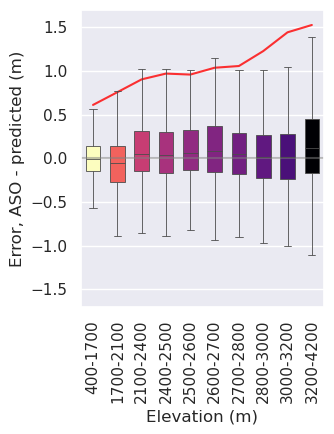

In [195]:
# elevation
df['elevation_bins'] = pd.qcut(df['elevation'], q=10, duplicates='drop')
df['bin_center'] = df['elevation_bins'].apply(lambda x: (x.left + x.right) / 2)

std_values = df.groupby('elevation_bins')['error'].std().reset_index()
std_values['bin_center'] = std_values['elevation_bins'].apply(lambda x: (x.left + x.right) / 2)

f, ax = plt.subplots(1, 1, figsize=(3.5, 4.5))
sns.lineplot(std_values['error']*2, ax=ax, c='red', alpha=0.8)
boxplot = sns.boxplot(x=df.elevation_bins,
            y=df.error,
            ax=ax, showfliers=False,
           linewidth=0.6, width=0.6, patch_artist=True)
ax.axhline(0, c='Gray', alpha=0.5)

# Calculate the center values of each bin
center_values = [(interval.left + interval.right) / 2 for interval in df.elevation_bins.cat.categories]

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(min(center_values), max(center_values))
colors = plt.cm.magma_r(norm(center_values))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax.tick_params(axis='x', rotation=90)

# Customize x-axis tick labels
new_labels = [f"{round(abs(interval.left)/100)*100}-{round(interval.right/100)*100}" for interval in df.elevation_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
ax.set_ylabel('Error, ASO - predicted (m)')
ax.set_xlabel('Elevation (m)')
ax.set_ylim(-1.7, 1.7)

# # Add colorbar
# sm = ScalarMappable(cmap='magma_r', norm=norm)
# sm.set_array([])
# cbar = f.colorbar(sm, ax=ax)
# cbar.set_label('elevation (m)', rotation=270, labelpad=15)

plt.tight_layout()

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_elevation_randomerror.png', dpi=400, bbox_inches='tight')

/tmp/ipykernel_72042/3849435805.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_values = df.groupby('elevation_bins')['standardized_error'].std().reset_index()
/tmp/ipykernel_72042/3849435805.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


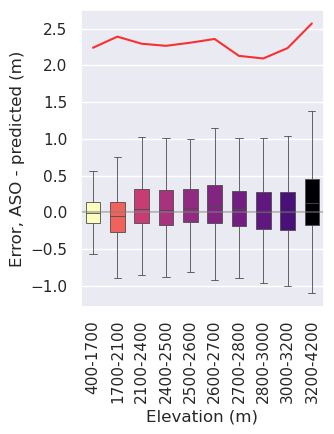

In [340]:
# elevation
df['elevation_bins'] = pd.qcut(df['elevation'], q=10, duplicates='drop')
df['bin_center'] = df['elevation_bins'].apply(lambda x: (x.left + x.right) / 2)

std_values = df.groupby('elevation_bins')['standardized_error'].std().reset_index()
std_values['bin_center'] = std_values['elevation_bins'].apply(lambda x: (x.left + x.right) / 2)

f, ax = plt.subplots(1, 1, figsize=(3.5, 4.5))
sns.lineplot(std_values['standardized_error']*2, ax=ax, c='red', alpha=0.8)
boxplot = sns.boxplot(x=df.elevation_bins,
            y=df.error,
            ax=ax, showfliers=False,
           linewidth=0.6, width=0.6, patch_artist=True)
ax.axhline(0, c='Gray', alpha=0.5)

# Calculate the center values of each bin
center_values = [(interval.left + interval.right) / 2 for interval in df.elevation_bins.cat.categories]

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(min(center_values), max(center_values))
colors = plt.cm.magma_r(norm(center_values))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax.tick_params(axis='x', rotation=90)

# Customize x-axis tick labels
new_labels = [f"{round(abs(interval.left)/100)*100}-{round(interval.right/100)*100}" for interval in df.elevation_bins.cat.categories]
ax.set_xticklabels(new_labels)
#ax.set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
ax.set_ylabel('Error, ASO - predicted (m)')
ax.set_xlabel('Elevation (m)')
#ax.set_ylim(-1.7, 1.7)

# # Add colorbar
# sm = ScalarMappable(cmap='magma_r', norm=norm)
# sm.set_array([])
# cbar = f.colorbar(sm, ax=ax)
# cbar.set_label('elevation (m)', rotation=270, labelpad=15)

plt.tight_layout()

#f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_elevation_randomerror.png', dpi=400, bbox_inches='tight')

## month

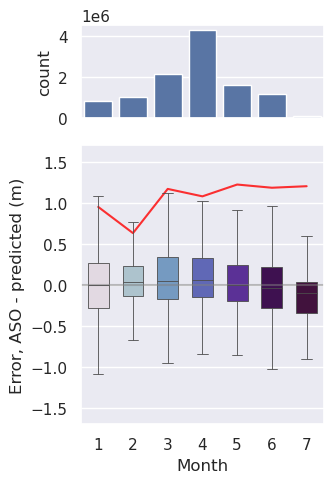

In [196]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df['month'] = df.time.dt.month
month_counts = df['month'].value_counts()
valid_months = month_counts[month_counts >= 1000].index
filtered_df = df[df['month'].isin(valid_months)]

std_values = filtered_df.groupby('month')['error'].std().reset_index()

f, ax = plt.subplots(2, 1, figsize=(3.5, 5), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
sns.barplot(filtered_df.groupby('month').count().aso_sd, ax=ax[0])
ax[0].set_xlim(0, 7)
ax[0].set_ylabel('count')
# ax[0].set_yscale('log')

# ax[0].set_yticks([10**3, 10**6])
# ax[0].get_yaxis().set_major_formatter(ScalarFormatter())

sns.lineplot(std_values['error']*2, ax=ax[1], c='red', alpha=0.8)
boxplot = sns.boxplot(x=filtered_df.month,
                      y=filtered_df.error,
                      ax=ax[1], showfliers=False,
                      linewidth=0.6, width=0.6, patch_artist=True)
ax[1].axhline(0, c='Gray', alpha=0.5)

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(1, 12)
colors = plt.cm.twilight(norm(std_values.month))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax[1].tick_params(axis='x')

ax[1].set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
ax[1].set_ylabel('Error, ASO - predicted (m)')
ax[1].set_xlabel('Month')
ax[1].set_ylim(-1.7, 1.7)

# # Add colorbar outside the plot area
# sm = ScalarMappable(cmap='twilight', norm=norm)
# sm.set_array([])
# cbar_ax = inset_axes(ax[1], width="2%", height="100%", loc='center left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax[1].transAxes, borderpad=0)
# cbar = f.colorbar(sm, cax=cbar_ax)
# cbar.set_label('month', rotation=270, labelpad=15)

# Adjust the space between subplots
plt.subplots_adjust(hspace=0.01)

plt.tight_layout()

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_month_randomerror.png', dpi=400, bbox_inches='tight')

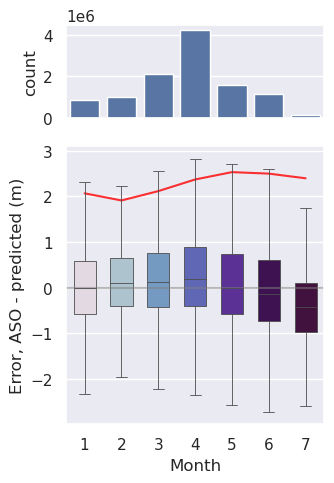

In [354]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df['month'] = df.time.dt.month
month_counts = df['month'].value_counts()
valid_months = month_counts[month_counts >= 1000].index
filtered_df = df[df['month'].isin(valid_months)]

std_values = filtered_df.groupby('month')['standardized_error'].std().reset_index()

f, ax = plt.subplots(2, 1, figsize=(3.5, 5), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
sns.barplot(filtered_df.groupby('month').count().aso_sd, ax=ax[0])
ax[0].set_xlim(0, 7)
ax[0].set_ylabel('count')
# ax[0].set_yscale('log')

# ax[0].set_yticks([10**3, 10**6])
# ax[0].get_yaxis().set_major_formatter(ScalarFormatter())

sns.lineplot(std_values['standardized_error']*2, ax=ax[1], c='red', alpha=0.8)
boxplot = sns.boxplot(x=filtered_df.month,
                      y=filtered_df.standardized_error,
                      ax=ax[1], showfliers=False,
                      linewidth=0.6, width=0.6, patch_artist=True)
ax[1].axhline(0, c='Gray', alpha=0.5)

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(1, 12)
colors = plt.cm.twilight(norm(std_values.month))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax[1].tick_params(axis='x')

#ax[1].set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
ax[1].set_ylabel('Error, ASO - predicted (m)')
ax[1].set_xlabel('Month')
#ax[1].set_ylim(-1.7, 1.7)

# # Add colorbar outside the plot area
# sm = ScalarMappable(cmap='twilight', norm=norm)
# sm.set_array([])
# cbar_ax = inset_axes(ax[1], width="2%", height="100%", loc='center left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax[1].transAxes, borderpad=0)
# cbar = f.colorbar(sm, cax=cbar_ax)
# cbar.set_label('month', rotation=270, labelpad=15)

# Adjust the space between subplots
plt.subplots_adjust(hspace=0.01)

plt.tight_layout()

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_month_randomerror_standardized.png', dpi=400, bbox_inches='tight')

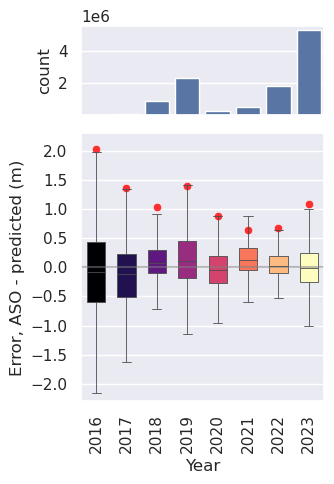

In [198]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df['year'] = df.time.dt.year
month_counts = df['year'].value_counts()
valid_months = month_counts[month_counts >= 1000].index
filtered_df = df[df['year'].isin(valid_months)]

std_values = filtered_df.groupby('year')['error'].std().reset_index()

f, ax = plt.subplots(2, 1, figsize=(3.5, 5), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
sns.barplot(filtered_df.groupby('year').count().aso_sd, ax=ax[0])
ax[0].set_xlim(0, 7)
ax[0].set_ylabel('count')
ax[0].set_yticks([2e6, 4e6])
# ax[0].set_yscale('log')

# ax[0].set_yticks([10**3, 10**6])
# ax[0].get_yaxis().set_major_formatter(ScalarFormatter())

sns.scatterplot(std_values['error']*2, ax=ax[1], c='red', alpha=0.8)
boxplot = sns.boxplot(x=filtered_df.year,
                      y=filtered_df.error,
                      ax=ax[1], showfliers=False,
                      linewidth=0.6, width=0.6, patch_artist=True)
ax[1].axhline(0, c='Gray', alpha=0.5)

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(2016, 2023)
colors = plt.cm.magma(norm(std_values.year))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax[1].tick_params(axis='x', rotation=90)

ax[1].set_yticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])
ax[1].set_ylabel('Error, ASO - predicted (m)')
ax[1].set_xlabel('Year')
ax[1].set_ylim(-2.3, 2.3)

# # Add colorbar outside the plot area
# sm = ScalarMappable(cmap='twilight', norm=norm)
# sm.set_array([])
# cbar_ax = inset_axes(ax[1], width="2%", height="100%", loc='center left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax[1].transAxes, borderpad=0)
# cbar = f.colorbar(sm, cax=cbar_ax)
# cbar.set_label('month', rotation=270, labelpad=15)

# Adjust the space between subplots
plt.subplots_adjust(hspace=0.01)

plt.tight_layout()

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_year_randomerror.png', dpi=400, bbox_inches='tight')

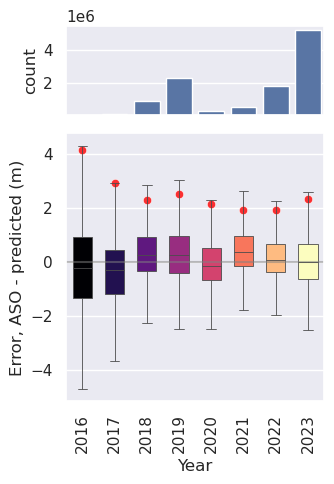

In [355]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df['year'] = df.time.dt.year
month_counts = df['year'].value_counts()
valid_months = month_counts[month_counts >= 1000].index
filtered_df = df[df['year'].isin(valid_months)]

std_values = filtered_df.groupby('year')['standardized_error'].std().reset_index()

f, ax = plt.subplots(2, 1, figsize=(3.5, 5), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
sns.barplot(filtered_df.groupby('year').count().aso_sd, ax=ax[0])
ax[0].set_xlim(0, 7)
ax[0].set_ylabel('count')
ax[0].set_yticks([2e6, 4e6])
# ax[0].set_yscale('log')

# ax[0].set_yticks([10**3, 10**6])
# ax[0].get_yaxis().set_major_formatter(ScalarFormatter())

sns.scatterplot(std_values['standardized_error']*2, ax=ax[1], c='red', alpha=0.8)
boxplot = sns.boxplot(x=filtered_df.year,
                      y=filtered_df.standardized_error,
                      ax=ax[1], showfliers=False,
                      linewidth=0.6, width=0.6, patch_artist=True)
ax[1].axhline(0, c='Gray', alpha=0.5)

# Normalize the center values to a range of [0, 1] for coloring
norm = plt.Normalize(2016, 2023)
colors = plt.cm.magma(norm(std_values.year))

# Set the colors of the boxes
for patch, color in zip(boxplot.patches, colors):
    patch.set_facecolor(color)

ax[1].tick_params(axis='x', rotation=90)

#ax[1].set_yticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])
ax[1].set_ylabel('Error, ASO - predicted (m)')
ax[1].set_xlabel('Year')
#ax[1].set_ylim(-2.3, 2.3)

# # Add colorbar outside the plot area
# sm = ScalarMappable(cmap='twilight', norm=norm)
# sm.set_array([])
# cbar_ax = inset_axes(ax[1], width="2%", height="100%", loc='center left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax[1].transAxes, borderpad=0)
# cbar = f.colorbar(sm, cax=cbar_ax)
# cbar.set_label('month', rotation=270, labelpad=15)

# Adjust the space between subplots
plt.subplots_adjust(hspace=0.01)

plt.tight_layout()

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_year_randomerror_standardized.png', dpi=400, bbox_inches='tight')

## mountain range

In [239]:
df = df.drop(['MapName_x', 'MapName_y'], axis=1)

In [219]:
import geopandas as gpd

In [240]:
mtn_gdf = gpd.read_file('../../../data/polygons/GMBA_Inventory_v2.0_standard_300.shp')

In [241]:
df['mtn_range'] = df['mtn_range'].round()

In [242]:
# Perform the merge
df = df.merge(mtn_gdf[['GMBA_V2_ID', 'MapName']], left_on='mtn_range', right_on='GMBA_V2_ID', how='left')

# Drop the GMBA_V2_ID column if you don't need it
df.drop(columns=['GMBA_V2_ID'], inplace=True)

In [356]:
# Count the number of rows for each MapName
mapname_counts = df['MapName'].value_counts()

# Filter out MapNames with fewer than 1000 rows
valid_mapnames = mapname_counts[mapname_counts >= 1000].index

# Keep only the rows with valid MapNames
filtered_df = df[df['MapName'].isin(valid_mapnames)]

/tmp/ipykernel_72042/2073708616.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([label.get_text().replace(' ', '\n') for label in xticklabels])


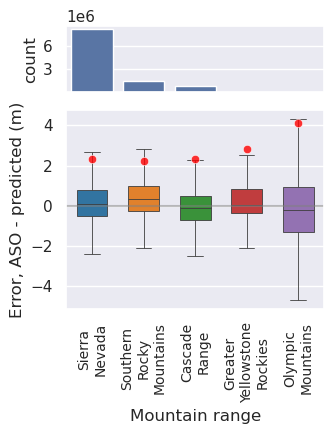

In [357]:
sns.set_theme()
std_values = filtered_df.groupby('MapName')['standardized_error'].std().reset_index()
order = filtered_df['MapName'].value_counts().index
std_values = std_values.set_index('MapName').loc[order].reset_index()

f, ax = plt.subplots(2, 1, figsize=(3.5, 4.5), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
sns.barplot(filtered_df.groupby('MapName').count().aso_sd, ax=ax[0], order=order)
ax[0].set_xlim(0, 7)
ax[0].set_ylabel('count')
ax[0].set_yticks([3e6, 6e6])
# ax[0].set_yscale('log')

# ax[0].set_yticks([10**3, 10**6])
# ax[0].get_yaxis().set_major_formatter(ScalarFormatter())

sns.scatterplot(std_values['standardized_error']*2, ax=ax[1], c='red', alpha=0.8, zorder=2)
boxplot = sns.boxplot(x=filtered_df.MapName,
            y=filtered_df.standardized_error,
                      hue=filtered_df.MapName, palette = 'tab10',
            ax=ax[1], showfliers=False,
           linewidth=0.6, width=0.6, order=order, zorder=1)
ax[1].axhline(0, c='Gray', alpha=0.5)

# violinplot = sns.violinplot(x=filtered_df.MapName,
#             y=filtered_df.error,
#                       hue=filtered_df.MapName, palette = 'tab10',
#             ax=ax[1], linewidth=0.6, width=0.7, order=order, zorder=1, legend=False)

xticklabels = ax[1].get_xticklabels()
ax[1].set_xticklabels([label.get_text().replace(' ', '\n') for label in xticklabels])

ax[1].tick_params(axis='x', rotation=90, labelsize=10)
#ax[1].set_yticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])

#ax[1].set_ylim(-2.3, 2.3)
ax[1].set_ylabel('Error, ASO - predicted (m)')
ax[1].set_xlabel('Mountain range')

plt.tight_layout()

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_mountainrange_randomerror_standardized.png', dpi=400, bbox_inches='tight')

## snow class

In [230]:
snow_class_dic = {'Tundra':1,
                  'Boreal Forest':2,
                  'Maritime':3,
                  'Ephemeral':4,
                  'Prairie':5,
                  'Montane Forest':6,
                  'Ice':7,
                  'Ocean':8,
                  'Fill':9}

reverse_snow_class_dic = {v: k for k, v in snow_class_dic.items()}

# Add the snow_class_label column to your dataframe
df['snow_class_label'] = df['snow_class'].map(reverse_snow_class_dic)

In [358]:
# Count the number of rows for each MapName
snow_class_counts = df['snow_class_label'].value_counts()

# Filter out MapNames with fewer than 1000 rows
valid_snow_classes = snow_class_counts[snow_class_counts >= 1000].index

# Keep only the rows with valid MapNames
filtered_df = df[df['snow_class_label'].isin(valid_snow_classes)]

/tmp/ipykernel_72042/1763262107.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([label.get_text().replace(' ', '\n') for label in xticklabels])


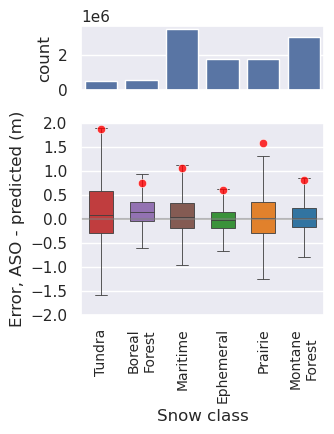

In [232]:
from matplotlib.ticker import ScalarFormatter

order = [label for label in list(snow_class_dic.keys()) if label in filtered_df.snow_class_label.values]

std_values = filtered_df.groupby('snow_class_label')['error'].std().reset_index()
std_values = std_values.set_index('snow_class_label').loc[order].reset_index()

f, ax = plt.subplots(2, 1, figsize=(3.5, 4.5), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
sns.barplot(filtered_df.groupby('snow_class_label').count().aso_sd, order=order, ax=ax[0])
ax[0].set_xlim(0, 7)
ax[0].set_ylabel('count')
# ax[0].set_yscale('log')

# ax[0].set_yticks([10**3, 10**6])
# ax[0].get_yaxis().set_major_formatter(ScalarFormatter())

boxplot = sns.boxplot(x=filtered_df.snow_class_label,
                      y=filtered_df.error,
                      hue=filtered_df.snow_class_label, order=order, palette = 'tab10',
                      ax=ax[1], showfliers=False, linewidth=0.6, width=0.6, legend=False, zorder=1)
ax[1].axhline(0, c='Gray', alpha=0.5)

# boxplot = sns.violinplot(x=filtered_df.snow_class_label,
#                       y=filtered_df.error,
#                       hue=filtered_df.snow_class_label, order=order, palette = 'tab10',
#                       ax=ax[1], linewidth=0.6, width=0.6, legend=False, zorder=1)
sns.scatterplot(std_values['error']*2, ax=ax[1], c='red', alpha=0.8, zorder=2)

xticklabels = ax[1].get_xticklabels()
ax[1].set_xticklabels([label.get_text().replace(' ', '\n') for label in xticklabels])

ax[1].tick_params(axis='x', rotation=90, labelsize=10)

ax[1].set_yticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])
ax[1].set_ylabel('Error, ASO - predicted (m)')
ax[1].set_xlabel('Snow class')
ax[1].set_ylim(-2.0, 2.0)

plt.tight_layout()

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_snowclass_randomerror.png', dpi=400, bbox_inches='tight')

/tmp/ipykernel_72042/194920333.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([label.get_text().replace(' ', '\n') for label in xticklabels])


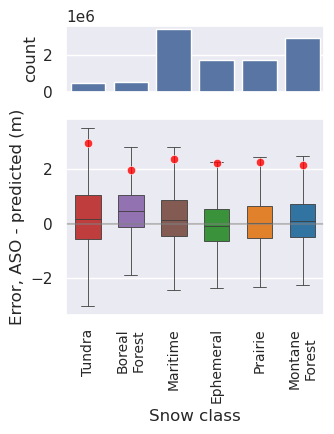

In [359]:
from matplotlib.ticker import ScalarFormatter

order = [label for label in list(snow_class_dic.keys()) if label in filtered_df.snow_class_label.values]

std_values = filtered_df.groupby('snow_class_label')['standardized_error'].std().reset_index()
std_values = std_values.set_index('snow_class_label').loc[order].reset_index()

f, ax = plt.subplots(2, 1, figsize=(3.5, 4.5), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
sns.barplot(filtered_df.groupby('snow_class_label').count().aso_sd, order=order, ax=ax[0])
ax[0].set_xlim(0, 7)
ax[0].set_ylabel('count')
# ax[0].set_yscale('log')

# ax[0].set_yticks([10**3, 10**6])
# ax[0].get_yaxis().set_major_formatter(ScalarFormatter())

boxplot = sns.boxplot(x=filtered_df.snow_class_label,
                      y=filtered_df.standardized_error,
                      hue=filtered_df.snow_class_label, order=order, palette = 'tab10',
                      ax=ax[1], showfliers=False, linewidth=0.6, width=0.6, legend=False, zorder=1)
ax[1].axhline(0, c='Gray', alpha=0.5)

# boxplot = sns.violinplot(x=filtered_df.snow_class_label,
#                       y=filtered_df.error,
#                       hue=filtered_df.snow_class_label, order=order, palette = 'tab10',
#                       ax=ax[1], linewidth=0.6, width=0.6, legend=False, zorder=1)
sns.scatterplot(std_values['standardized_error']*2, ax=ax[1], c='red', alpha=0.8, zorder=2)

xticklabels = ax[1].get_xticklabels()
ax[1].set_xticklabels([label.get_text().replace(' ', '\n') for label in xticklabels])

ax[1].tick_params(axis='x', rotation=90, labelsize=10)

#ax[1].set_yticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])
ax[1].set_ylabel('Error, ASO - predicted (m)')
ax[1].set_xlabel('Snow class')
#ax[1].set_ylim(-2.0, 2.0)

plt.tight_layout()

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_snowclass_randomerror_standardized.png', dpi=400, bbox_inches='tight')

## heatmaps--random error distribution over two variables

In [183]:
grouped_df = df.groupby(['predicted_sd_bins', 'elevation_bins']).agg({'error': ['std', 'count']}).reset_index()
grouped_df.columns = ['predicted_sd', 'elevation', 'std', 'count']
grouped_df = grouped_df[grouped_df['count'] >= 1000]
heatmap_data = grouped_df.pivot(index='predicted_sd', columns='elevation', values='std')

/tmp/ipykernel_72042/1923436716.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['predicted_sd_bins', 'elevation_bins']).agg({'error': ['std', 'count']}).reset_index()


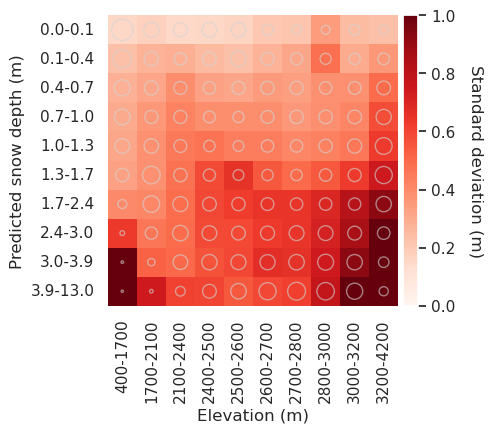

In [185]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create the plot
f, ax = plt.subplots(figsize=(4, 4))
heatmap = sns.heatmap(heatmap_data, vmin=0, vmax=1, cmap='Reds', ax=ax, cbar=False)

# Customize x-axis tick labels
new_labels = [f"{round(abs(interval.left)/100)*100}-{round(interval.right/100)*100}" for interval in df.elevation_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_xlabel('Elevation (m)')

# Customize y-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.predicted_sd_bins.cat.categories]
ax.set_yticklabels(new_labels)
ax.set_ylabel('Predicted snow depth (m)')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add colorbar with adjusted size
cbar = plt.colorbar(heatmap.get_children()[0], cax=cax)
cbar.set_label('Standard deviation (m)', rotation=270, labelpad=20)

# Plot scatter points on top of heatmap
for i in range(len(grouped_df)):
    x = grouped_df['elevation'].cat.codes[i]
    y = grouped_df['predicted_sd'].cat.codes[i]
    size = grouped_df['count'][i] / 1200  # Scale the size for better visualization
    ax.scatter(x + 0.5, y + 0.5, s=size, c='none', edgecolor='lightgray', alpha=0.6)

ax.set_aspect('equal')

#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_pred_sd_elevation_heatmap.png', dpi=400, bbox_inches='tight')

In [368]:
grouped_df = df.groupby(['predicted_sd_bins', 'slope_bins']).agg({'error': ['std', 'count']}).reset_index()
grouped_df.columns = ['predicted_sd', 'slope', 'std', 'count']
grouped_df = grouped_df[grouped_df['count'] >= 1000]
heatmap_data = grouped_df.pivot(index='predicted_sd', columns='slope', values='std')

/tmp/ipykernel_72042/3606187312.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['predicted_sd_bins', 'slope_bins']).agg({'error': ['std', 'count']}).reset_index()


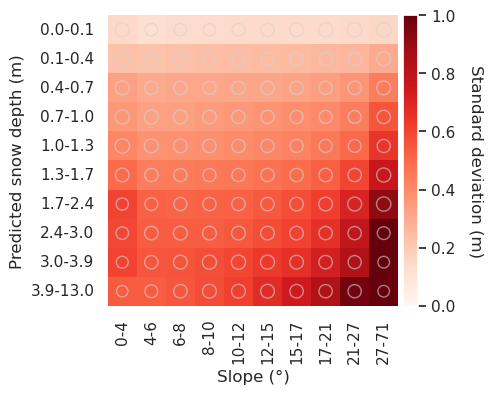

In [370]:
# Create the plot
f, ax = plt.subplots(figsize=(4, 4))
heatmap = sns.heatmap(heatmap_data, vmin=0, vmax=1, cmap='Reds', ax=ax, cbar=False)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.0f}-{interval.right:.0f}" for interval in df.slope_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_xlabel('Slope (\N{DEGREE SIGN})')

# Customize y-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.predicted_sd_bins.cat.categories]
ax.set_yticklabels(new_labels)
ax.set_ylabel('Predicted snow depth (m)')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add colorbar with adjusted size
cbar = plt.colorbar(heatmap.get_children()[0], cax=cax)
cbar.set_label('Standard deviation (m)', rotation=270, labelpad=20)

# Plot scatter points on top of heatmap
for i in range(len(grouped_df)):
    x = grouped_df['slope'].cat.codes[i]
    y = grouped_df['predicted_sd'].cat.codes[i]
    size = grouped_df['count'][i] / 1200  # Scale the size for better visualization
    ax.scatter(x + 0.5, y + 0.5, s=size, c='none', edgecolor='lightgray', alpha=0.6)

ax.set_aspect('equal')

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_pred_sd_slope_heatmap.png', dpi=400, bbox_inches='tight')

In [371]:
grouped_df = df.groupby(['predicted_sd_bins', 'fcf_bins']).agg({'error': ['std', 'count']}).reset_index()
grouped_df.columns = ['predicted_sd', 'fcf', 'std', 'count']
grouped_df = grouped_df[grouped_df['count'] >= 1000]
heatmap_data = grouped_df.pivot(index='predicted_sd', columns='fcf', values='std')

/tmp/ipykernel_72042/2812623035.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['predicted_sd_bins', 'fcf_bins']).agg({'error': ['std', 'count']}).reset_index()


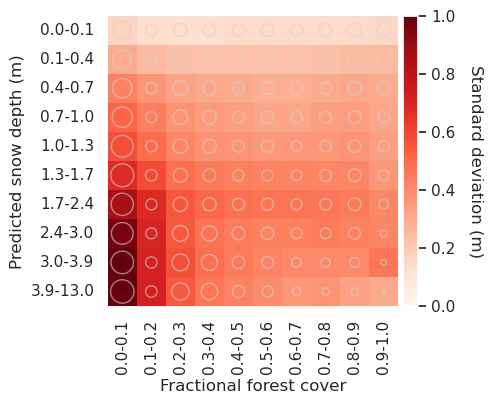

In [372]:
# Create the plot
f, ax = plt.subplots(figsize=(4, 4))
heatmap = sns.heatmap(heatmap_data, vmin=0, vmax=1, cmap='Reds', ax=ax, cbar=False)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.fcf_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_xlabel('Fractional forest cover')

# Customize y-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.predicted_sd_bins.cat.categories]
ax.set_yticklabels(new_labels)
ax.set_ylabel('Predicted snow depth (m)')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add colorbar with adjusted size
cbar = plt.colorbar(heatmap.get_children()[0], cax=cax)
cbar.set_label('Standard deviation (m)', rotation=270, labelpad=20)

# Plot scatter points on top of heatmap
for i in range(len(grouped_df)):
    x = grouped_df['fcf'].cat.codes[i]
    y = grouped_df['predicted_sd'].cat.codes[i]
    size = grouped_df['count'][i] / 1200  # Scale the size for better visualization
    ax.scatter(x + 0.5, y + 0.5, s=size, c='none', edgecolor='lightgray', alpha=0.6)

ax.set_aspect('equal')

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_pred_sd_fcf_heatmap.png', dpi=400, bbox_inches='tight')

In [384]:
grouped_df = df.groupby(['predicted_sd_bins', 'aspect_bins']).agg({'error': ['std', 'count']}).reset_index()
grouped_df.columns = ['predicted_sd', 'aspect', 'std', 'count']
grouped_df = grouped_df[grouped_df['count'] >= 1000]
heatmap_data = grouped_df.pivot(index='predicted_sd', columns='aspect', values='std')

/tmp/ipykernel_72042/4257897590.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['predicted_sd_bins', 'aspect_bins']).agg({'error': ['std', 'count']}).reset_index()


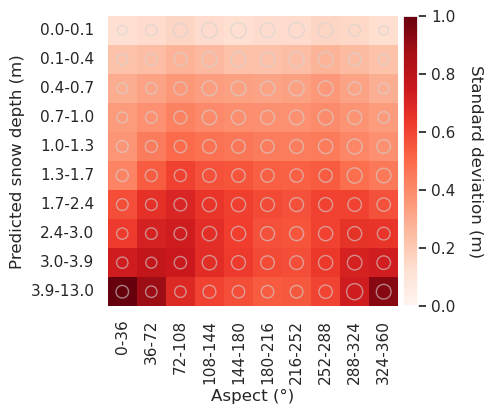

In [386]:
# Create the plot
f, ax = plt.subplots(figsize=(4, 4))
heatmap = sns.heatmap(heatmap_data, vmin=0, vmax=1, cmap='Reds', ax=ax, cbar=False)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.0f}-{interval.right:.0f}" for interval in df.aspect_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_xlabel('Aspect (\N{DEGREE SIGN})')

# Customize y-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.predicted_sd_bins.cat.categories]
ax.set_yticklabels(new_labels)
ax.set_ylabel('Predicted snow depth (m)')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add colorbar with adjusted size
cbar = plt.colorbar(heatmap.get_children()[0], cax=cax)
cbar.set_label('Standard deviation (m)', rotation=270, labelpad=20)

# Plot scatter points on top of heatmap
for i in range(len(grouped_df)):
    x = grouped_df['aspect'].cat.codes[i]
    y = grouped_df['predicted_sd'].cat.codes[i]
    size = grouped_df['count'][i] / 1200  # Scale the size for better visualization
    ax.scatter(x + 0.5, y + 0.5, s=size, c='none', edgecolor='lightgray', alpha=0.6)

ax.set_aspect('equal')

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_pred_sd_aspect_heatmap.png', dpi=400, bbox_inches='tight')

In [387]:
grouped_df = df.groupby(['slope_bins', 'aspect_bins']).agg({'error': ['std', 'count']}).reset_index()
grouped_df.columns = ['slope', 'aspect', 'std', 'count']
grouped_df = grouped_df[grouped_df['count'] >= 1000]
heatmap_data = grouped_df.pivot(index='slope', columns='aspect', values='std')

/tmp/ipykernel_72042/3368664213.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['slope_bins', 'aspect_bins']).agg({'error': ['std', 'count']}).reset_index()


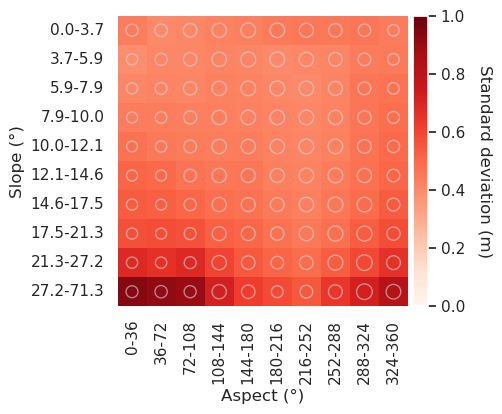

In [388]:
# Create the plot
f, ax = plt.subplots(figsize=(4, 4))
heatmap = sns.heatmap(heatmap_data, vmin=0, vmax=1, cmap='Reds', ax=ax, cbar=False)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.0f}-{interval.right:.0f}" for interval in df.aspect_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_xlabel('Aspect (\N{DEGREE SIGN})')

# Customize y-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.slope_bins.cat.categories]
ax.set_yticklabels(new_labels)
ax.set_ylabel('Slope (\N{DEGREE SIGN})')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add colorbar with adjusted size
cbar = plt.colorbar(heatmap.get_children()[0], cax=cax)
cbar.set_label('Standard deviation (m)', rotation=270, labelpad=20)

# Plot scatter points on top of heatmap
for i in range(len(grouped_df)):
    x = grouped_df['aspect'].cat.codes[i]
    y = grouped_df['slope'].cat.codes[i]
    size = grouped_df['count'][i] / 1200  # Scale the size for better visualization
    ax.scatter(x + 0.5, y + 0.5, s=size, c='none', edgecolor='lightgray', alpha=0.6)

ax.set_aspect('equal')

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_slope_aspect_heatmap.png', dpi=400, bbox_inches='tight')

In [392]:
grouped_df = df.groupby(['slope_bins', 'aspect_bins']).agg({'error': ['mean', 'count']}).reset_index()
grouped_df.columns = ['slope', 'aspect', 'mean', 'count']
grouped_df = grouped_df[grouped_df['count'] >= 1000]
heatmap_data = grouped_df.pivot(index='slope', columns='aspect', values='mean')

/tmp/ipykernel_72042/1406232762.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['slope_bins', 'aspect_bins']).agg({'error': ['mean', 'count']}).reset_index()


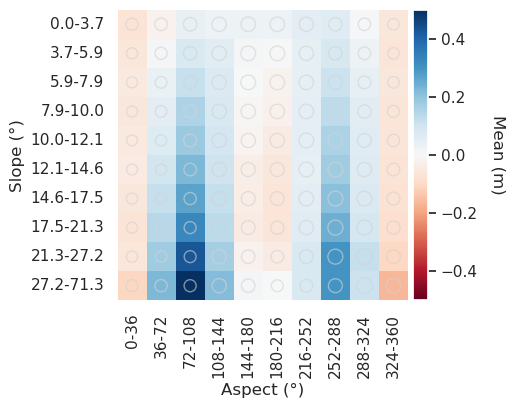

In [397]:
# Create the plot
f, ax = plt.subplots(figsize=(4, 4))
heatmap = sns.heatmap(heatmap_data, vmin=-0.5, vmax=0.5, cmap='RdBu', ax=ax, cbar=False)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.0f}-{interval.right:.0f}" for interval in df.aspect_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_xlabel('Aspect (\N{DEGREE SIGN})')

# Customize y-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.slope_bins.cat.categories]
ax.set_yticklabels(new_labels)
ax.set_ylabel('Slope (\N{DEGREE SIGN})')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add colorbar with adjusted size
cbar = plt.colorbar(heatmap.get_children()[0], cax=cax)
cbar.set_label('Mean (m)', rotation=270, labelpad=20)

# Plot scatter points on top of heatmap
for i in range(len(grouped_df)):
    x = grouped_df['aspect'].cat.codes[i]
    y = grouped_df['slope'].cat.codes[i]
    size = grouped_df['count'][i] / 1200  # Scale the size for better visualization
    ax.scatter(x + 0.5, y + 0.5, s=size, c='none', edgecolor='lightgray', alpha=0.6)

ax.set_aspect('equal')

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_slope_aspect_BIAS_heatmap.png', dpi=400, bbox_inches='tight')

In [389]:
grouped_df = df.groupby(['slope_bins', 'fcf_bins']).agg({'error': ['std', 'count']}).reset_index()
grouped_df.columns = ['slope', 'fcf', 'std', 'count']
grouped_df = grouped_df[grouped_df['count'] >= 1000]
heatmap_data = grouped_df.pivot(index='slope', columns='fcf', values='std')

/tmp/ipykernel_72042/1233774470.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['slope_bins', 'fcf_bins']).agg({'error': ['std', 'count']}).reset_index()


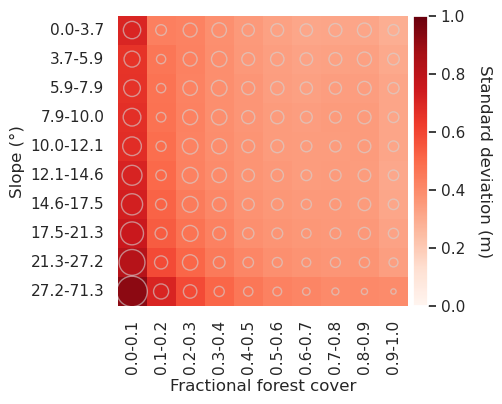

In [391]:
# Create the plot
f, ax = plt.subplots(figsize=(4, 4))
heatmap = sns.heatmap(heatmap_data, vmin=0, vmax=1, cmap='Reds', ax=ax, cbar=False)

# Customize x-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.fcf_bins.cat.categories]
ax.set_xticklabels(new_labels)
ax.set_xlabel('Fractional forest cover')

# Customize y-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.slope_bins.cat.categories]
ax.set_yticklabels(new_labels)
ax.set_ylabel('Slope (\N{DEGREE SIGN})')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add colorbar with adjusted size
cbar = plt.colorbar(heatmap.get_children()[0], cax=cax)
cbar.set_label('Standard deviation (m)', rotation=270, labelpad=20)

# Plot scatter points on top of heatmap
for i in range(len(grouped_df)):
    x = grouped_df['fcf'].cat.codes[i]
    y = grouped_df['slope'].cat.codes[i]
    size = grouped_df['count'][i] / 1200  # Scale the size for better visualization
    ax.scatter(x + 0.5, y + 0.5, s=size, c='none', edgecolor='lightgray', alpha=0.6)

ax.set_aspect('equal')

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_slope_fcf_heatmap.png', dpi=400, bbox_inches='tight')

In [191]:
grouped_df = df.groupby(['predicted_sd_bins', 'month']).agg({'error': ['std', 'count']}).reset_index()
grouped_df.columns = ['predicted_sd', 'month', 'std', 'count']
grouped_df = grouped_df[grouped_df['count'] >= 1000]
heatmap_data = grouped_df.pivot(index='predicted_sd', columns='month', values='std')

/tmp/ipykernel_72042/1577843986.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['predicted_sd_bins', 'month']).agg({'error': ['std', 'count']}).reset_index()


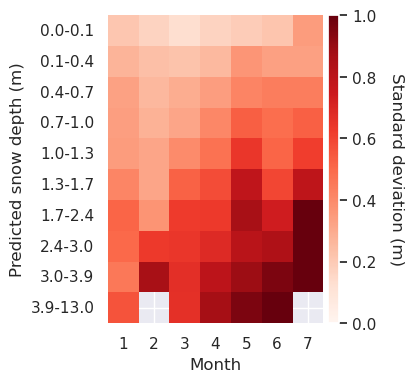

In [192]:
# Create the plot
f, ax = plt.subplots(figsize=(4, 4))
heatmap = sns.heatmap(heatmap_data, vmin=0, vmax=1, cmap='Reds', ax=ax, cbar=False)

ax.set_xlabel('Month')

# Customize y-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.predicted_sd_bins.cat.categories]
ax.set_yticklabels(new_labels)
ax.set_ylabel('Predicted snow depth (m)')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add colorbar with adjusted size
cbar = plt.colorbar(heatmap.get_children()[0], cax=cax)
cbar.set_label('Standard deviation (m)', rotation=270, labelpad=20)

# # Plot scatter points on top of heatmap
# for i in range(len(grouped_df)):
#     x = grouped_df['month'].cat.codes[i]
#     y = grouped_df['predicted_sd'].cat.codes[i]
#     size = grouped_df['count'][i] / 1200  # Scale the size for better visualization
#     ax.scatter(x + 0.5, y + 0.5, s=size, c='none', edgecolor='lightgray', alpha=0.6)

ax.set_aspect('equal')

#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_pred_sd_month_heatmap.png', dpi=400, bbox_inches='tight')

In [398]:
grouped_df = df.groupby(['predicted_sd_bins', 'month']).agg({'error': ['mean', 'count']}).reset_index()
grouped_df.columns = ['predicted_sd', 'month', 'mean', 'count']
grouped_df = grouped_df[grouped_df['count'] >= 1000]
heatmap_data = grouped_df.pivot(index='predicted_sd', columns='month', values='mean')

/tmp/ipykernel_72042/2346836453.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['predicted_sd_bins', 'month']).agg({'error': ['mean', 'count']}).reset_index()


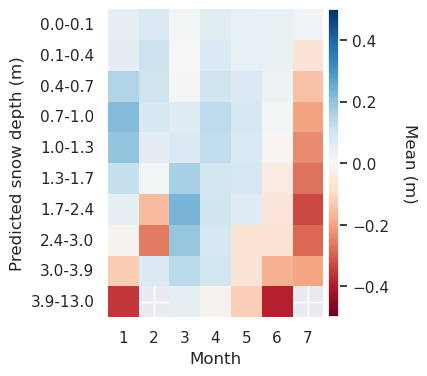

In [401]:
# Create the plot
f, ax = plt.subplots(figsize=(4, 4))
heatmap = sns.heatmap(heatmap_data, vmin=-0.5, vmax=0.5, cmap='RdBu', ax=ax, cbar=False)

ax.set_xlabel('Month')

# Customize y-axis tick labels
new_labels = [f"{abs(interval.left):.1f}-{interval.right:.1f}" for interval in df.predicted_sd_bins.cat.categories]
ax.set_yticklabels(new_labels)
ax.set_ylabel('Predicted snow depth (m)')

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add colorbar with adjusted size
cbar = plt.colorbar(heatmap.get_children()[0], cax=cax)
cbar.set_label('Mean (m)', rotation=270, labelpad=20)

# # Plot scatter points on top of heatmap
# for i in range(len(grouped_df)):
#     x = grouped_df['month'].cat.codes[i]
#     y = grouped_df['predicted_sd'].cat.codes[i]
#     size = grouped_df['count'][i] / 1200  # Scale the size for better visualization
#     ax.scatter(x + 0.5, y + 0.5, s=size, c='none', edgecolor='lightgray', alpha=0.6)

ax.set_aspect('equal')

#f.savefig('../../../figs/quinn_ResDepthv10_256epochs_pred_sd_month_heatmap.png', dpi=400, bbox_inches='tight')

## standardize error with predicted error

In [337]:
####### FOUR VARIABLES ##################

from scipy.interpolate import griddata

# Calculate bin centers for your variables
def calculate_bin_centers(bins):
    return [(interval.left + interval.right) / 2 for interval in bins]

# Calculate bin centers
df['predicted_sd_center'] = df['predicted_sd_bins'].apply(lambda x: (x.left + x.right) / 2)
df['slope_center'] = df['slope_bins'].apply(lambda x: (x.left + x.right) / 2)
df['fcf_center'] = df['fcf_bins'].apply(lambda x: (x.left + x.right) / 2)
df['aspect_center'] = df['aspect_bins'].apply(lambda x: (x.left + x.right) / 2)

grouped = df.groupby(['predicted_sd_bins', 'slope_bins', 'fcf_bins', 'aspect_bins']).agg({'error': ['std', 'count']}).reset_index()
grouped.columns = ['predicted_sd_bins', 'slope_bins', 'fcf_bins', 'aspect_bins', 'std', 'count']

# Prepare data for interpolation
centers = grouped.copy()
centers['predicted_sd_center'] = calculate_bin_centers(centers['predicted_sd_bins'])
centers['slope_center'] = calculate_bin_centers(centers['slope_bins'])
centers['fcf_center'] = calculate_bin_centers(centers['fcf_bins'])
centers['aspect_center'] = calculate_bin_centers(centers['aspect_bins'])

# Create points for interpolation
points = centers[['predicted_sd_center', 'slope_center', 'fcf_center', 'aspect_center']].values
values = centers['std'].values

# Create a grid for interpolation
grid_x, grid_y, grid_z, grid_w = np.meshgrid(
    calculate_bin_centers(df['predicted_sd_bins'].cat.categories),
    calculate_bin_centers(df['slope_bins'].cat.categories),
    calculate_bin_centers(df['fcf_bins'].cat.categories),
    calculate_bin_centers(df['aspect_bins'].cat.categories),
    indexing='ij'
)

# Flatten the grid arrays and interpolate
grid_points = np.vstack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel(), grid_w.ravel()]).T
interpolated_std = griddata(points, values, grid_points, method='linear')

# Reshape interpolated values back to the grid shape
interpolated_std = interpolated_std.reshape(len(grid_x), len(grid_y), len(grid_z), len(grid_w))

# Fill remaining NaNs using 'nearest' method
nan_mask = np.isnan(interpolated_std)
if np.any(nan_mask):
    # Interpolate using griddata with 'nearest' method for NaNs only
    nearest_values = griddata(points, values, grid_points, method='nearest', fill_value=np.nan).reshape((10, 10, 10, 10))
    interpolated_std[nan_mask] = nearest_values[nan_mask]

/tmp/ipykernel_72042/3592158446.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['predicted_sd_bins', 'slope_bins', 'fcf_bins', 'elevation_bins']).agg({'error': ['std', 'count']}).reset_index()


In [245]:
# ####### TWO VARIABLES ##################

# from scipy.interpolate import griddata

# # Calculate bin centers for your variables
# def calculate_bin_centers(bins):
#     return [(interval.left + interval.right) / 2 for interval in bins]

# # Calculate bin centers
# df['predicted_sd_center'] = df['predicted_sd_bins'].apply(lambda x: (x.left + x.right) / 2)
# df['slope_center'] = df['slope_bins'].apply(lambda x: (x.left + x.right) / 2)

# grouped = df.groupby(['predicted_sd_bins', 'slope_bins']).agg({'error': ['std', 'count']}).reset_index()
# grouped.columns = ['predicted_sd_bins', 'slope_bins', 'std', 'count']

# # Prepare data for interpolation
# centers = grouped.copy()
# centers['predicted_sd_center'] = calculate_bin_centers(centers['predicted_sd_bins'])
# centers['slope_center'] = calculate_bin_centers(centers['slope_bins'])

# # Create points for interpolation
# points = centers[['predicted_sd_center', 'slope_center']].values
# values = centers['std'].values

# # Create a grid for interpolation
# grid_x, grid_y = np.meshgrid(
#     calculate_bin_centers(df['predicted_sd_bins'].cat.categories),
#     calculate_bin_centers(df['slope_bins'].cat.categories),
#     indexing='ij'
# )

# # Flatten the grid arrays and interpolate
# grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
# interpolated_std = griddata(points, values, grid_points, method='linear')

# # Reshape interpolated values back to the grid shape
# interpolated_std = interpolated_std.reshape(len(grid_x), len(grid_y))

# # Fill remaining NaNs using 'nearest' method
# nan_mask = np.isnan(interpolated_std)
# if np.any(nan_mask):
#     # Interpolate using griddata with 'nearest' method for NaNs only
#     nearest_values = griddata(points, values, grid_points, method='nearest', fill_value=np.nan).reshape((10, 10))
#     interpolated_std[nan_mask] = nearest_values[nan_mask]

/tmp/ipykernel_72042/2984209233.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['predicted_sd_bins', 'slope_bins']).agg({'error': ['std', 'count']}).reset_index()


In [325]:
# ####### THREE VARIABLES ##################

# from scipy.interpolate import griddata

# # Calculate bin centers for your variables
# def calculate_bin_centers(bins):
#     return [(interval.left + interval.right) / 2 for interval in bins]

# # Calculate bin centers
# df['aspect_center'] = df['aspect_bins'].apply(lambda x: (x.left + x.right) / 2)
# df['slope_center'] = df['slope_bins'].apply(lambda x: (x.left + x.right) / 2)
# df['fcf_center'] = df['fcf_bins'].apply(lambda x: (x.left + x.right) / 2)

# grouped = df.groupby(['aspect_bins', 'slope_bins', 'fcf_bins']).agg({'error': ['std', 'count']}).reset_index()
# grouped.columns = ['aspect_bins', 'slope_bins', 'fcf_bins', 'std', 'count']

# # Prepare data for interpolation
# centers = grouped.copy()
# centers['aspect_center'] = calculate_bin_centers(centers['aspect_bins'])
# centers['slope_center'] = calculate_bin_centers(centers['slope_bins'])
# centers['fcf_center'] = calculate_bin_centers(centers['fcf_bins'])

# # Create points for interpolation
# points = centers[['aspect_center', 'slope_center', 'fcf_center']].values
# values = centers['std'].values

# # Create a grid for interpolation
# grid_x, grid_y, grid_z = np.meshgrid(
#     calculate_bin_centers(df['aspect_bins'].cat.categories),
#     calculate_bin_centers(df['slope_bins'].cat.categories),
#     calculate_bin_centers(df['fcf_bins'].cat.categories),
#     indexing='ij'
# )

# # Flatten the grid arrays and interpolate
# grid_points = np.vstack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()]).T
# interpolated_std = griddata(points, values, grid_points, method='linear')

# # Reshape interpolated values back to the grid shape
# interpolated_std = interpolated_std.reshape(len(grid_x), len(grid_y), len(grid_z))

# # Fill remaining NaNs using 'nearest' method
# nan_mask = np.isnan(interpolated_std)
# if np.any(nan_mask):
#     # Interpolate using griddata with 'nearest' method for NaNs only
#     nearest_values = griddata(points, values, grid_points, method='nearest', fill_value=np.nan).reshape((10, 10, 10))
#     interpolated_std[nan_mask] = nearest_values[nan_mask]

/tmp/ipykernel_72042/280856266.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['aspect_bins', 'slope_bins', 'fcf_bins']).agg({'error': ['std', 'count']}).reset_index()


In [338]:
# Map interpolated std values to the original DataFrame using numpy indexing
df['interpolated_std'] = interpolated_std[
    df['predicted_sd_bins'].cat.codes.values,
    df['slope_bins'].cat.codes.values,
    df['fcf_bins'].cat.codes.values,
    df['aspect_bins'].cat.codes.values
]

# Define a minimum threshold for std
min_std_threshold = 0.01

# Replace std values below the threshold with the threshold
df['interpolated_std'] = np.maximum(df['interpolated_std'], min_std_threshold)

# Calculate standardized error
df['standardized_error'] = df['error'] / df['interpolated_std']

# Divide error by the interpolated std
df['standardized_error'] = df['error'] / df['interpolated_std']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['standardized_error'])

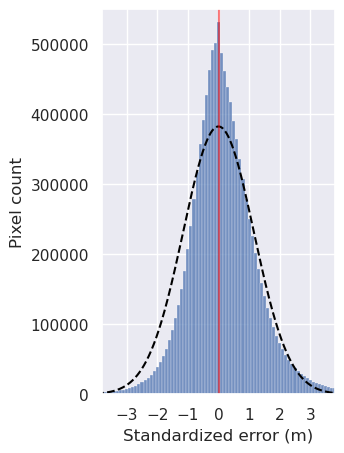

In [360]:
from scipy.stats import norm

df = df[(df.standardized_error >= -8) & (df.standardized_error <= 8)]

# Generate x values and corresponding normal PDF values scaled to match the histogram's area
x = np.linspace(-4, 4, 1000)
pdf = norm.pdf(x, loc=0, scale=np.std(df.standardized_error))

# Scale the PDF to match the histogram count scale
bin_width = 0.1
pdf_scaled = pdf * len(df.standardized_error) * bin_width

# plot distribution of error after standardizing
f, ax = plt.subplots(figsize=(3, 5))
sns.histplot(df.standardized_error, ax=ax, bins=np.arange(-4, 4, 0.1)-0.05)
# Plot the normal distribution
ax.plot(x, pdf_scaled, color='black', linestyle='--', label='Normal PDF')
ax.set_xlim(-3.8, 3.8)
ax.set_ylim(0, 0.55*1e6)
ax.set_xlabel('Standardized error (m)')
ax.set_ylabel('Pixel count')
ax.axvline(0, c='red', alpha=0.5)
ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
#ax.legend()

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_standardized_errorhist.png', dpi=400, bbox_inches='tight')

In [320]:
# def plot_standardized_error_distribution(df, variables, error_col='error', bin_suffix='_bins', min_std_threshold=0.01):
#     """
#     Plot standardized error distribution compared to a normal distribution.

#     Parameters:
#         df (pd.DataFrame): Input DataFrame containing error and binned variables.
#         variables (list of str): List of 3 variable names to use for heteroscedasticity modeling.
#         error_col (str): Name of the column containing error.
#         bin_suffix (str): Suffix used for binned versions of the variables.
#         min_std_threshold (float): Minimum standard deviation to enforce.

#     Returns:
#         None
#     """
#     assert len(variables) == 3, "Exactly three variables must be provided."

#     # Unpack variable names
#     var1, var2, var3 = variables
#     bin1, bin2, bin3 = [v + bin_suffix for v in variables]

#     # Compute bin centers
#     for v, b in zip(variables, [bin1, bin2, bin3]):
#         df[f'{v}_center'] = df[b].apply(lambda x: (x.left + x.right) / 2)

#     # Group and compute std dev of error
#     grouped = df.groupby([bin1, bin2, bin3]).agg({error_col: ['std', 'count']}).reset_index()
#     grouped.columns = [bin1, bin2, bin3, 'std', 'count']

#     # Bin centers
#     grouped[f'{var1}_center'] = [(i.left + i.right) / 2 for i in grouped[bin1]]
#     grouped[f'{var2}_center'] = [(i.left + i.right) / 2 for i in grouped[bin2]]
#     grouped[f'{var3}_center'] = [(i.left + i.right) / 2 for i in grouped[bin3]]

#     # Interpolation points and values
#     points = grouped[[f'{var1}_center', f'{var2}_center', f'{var3}_center']].values
#     values = grouped['std'].values

#     # 3D grid over bin centers
#     grid_x, grid_y, grid_z = np.meshgrid(
#         [(i.left + i.right) / 2 for i in df[bin1].cat.categories],
#         [(i.left + i.right) / 2 for i in df[bin2].cat.categories],
#         [(i.left + i.right) / 2 for i in df[bin3].cat.categories],
#         indexing='ij'
#     )

#     grid_points = np.vstack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()]).T
#     interpolated_std = griddata(points, values, grid_points, method='linear')
#     interpolated_std = interpolated_std.reshape(grid_x.shape)

#     # Fill NaNs with nearest neighbor interpolation
#     if np.any(np.isnan(interpolated_std)):
#         nearest_values = griddata(points, values, grid_points, method='nearest').reshape(grid_x.shape)
#         interpolated_std[np.isnan(interpolated_std)] = nearest_values[np.isnan(interpolated_std)]

#     # Map interpolated std to the df using bin codes
#     df['interpolated_std'] = interpolated_std[
#         df[bin1].cat.codes.values,
#         df[bin2].cat.codes.values,
#         df[bin3].cat.codes.values
#     ]

#     # Apply minimum threshold
#     df['interpolated_std'] = np.maximum(df['interpolated_std'], min_std_threshold)

#     # Standardize error
#     df['standardized_error'] = df[error_col] / df['interpolated_std']
#     df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['standardized_error'])
#     df = df[(df.standardized_error >= -8) & (df.standardized_error <= 8)]

#     print(f'median: {df.standardized_error.median()}')
#     print(f'nmad: {nmad(df.standardized_error)}')
#     print(f'skewness: {df.standardized_error.skew()}')
#     print(f'excess kurtosis: {df.standardized_error.kurtosis() - 3}')

#     # Plotting
#     f, ax = plt.subplots(figsize=(2.5, 4))
#     x = np.linspace(-3, 3, 500)
#     pdf = norm.pdf(x, loc=0, scale=np.std(df.standardized_error))
#     bin_width = 0.1
#     pdf_scaled = pdf * len(df.standardized_error) * bin_width

#     sns.histplot(df.standardized_error, ax=ax, bins=np.arange(-3, 3, 0.1)-0.05)
#     ax.plot(x, pdf_scaled, color='black', linestyle='--', label='Normal PDF')
#     ax.set_xlim(-3.3, 3.3)
#     ax.set_ylim(0, 0.6 * 1e6)
#     ax.set_xlabel('error, standardized (m)')
#     ax.set_ylabel('count')
#     ax.axvline(0, c='red', alpha=0.5)
#     ax.set_xticks([-2, -1, 0, 1, 2])
#     ax.legend()
#     plt.tight_layout()
#     plt.show()


In [321]:
# import itertools
# import os

# def run_all_triplet_combinations(
#     df, 
#     variable_list, 
#     error_col='error', 
#     bin_suffix='_bins',
#     save_dir=None,
#     show_plots=True
# ):
#     """
#     Run standardized error analysis for all combinations of three variables.

#     Parameters:
#         df (pd.DataFrame): Input DataFrame.
#         variable_list (list of str): Variables to consider.
#         error_col (str): Name of the error column.
#         bin_suffix (str): Suffix used for binned variable columns.
#         save_dir (str or None): If provided, saves plots to this directory.
#         show_plots (bool): Whether to display plots inline.

#     Returns:
#         None
#     """
#     from matplotlib import pyplot as plt

#     combos = list(itertools.combinations(variable_list, 3))

#     if save_dir:
#         os.makedirs(save_dir, exist_ok=True)

#     for combo in combos:
#         print(f"Processing combination: {combo}")
#         plt.clf()
#         plot_standardized_error_distribution(
#             df.copy(), 
#             list(combo), 
#             error_col=error_col, 
#             bin_suffix=bin_suffix
#         )
#         if save_dir:
#             filename = f"std_error_hist__{'_'.join(combo)}.png"
#             plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
#         if not show_plots:
#             plt.close()


Processing combination: ('predicted_sd', 'slope', 'aspect')


/tmp/ipykernel_72042/2660494904.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2, bin3]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.07223346247751589
nmad: 0.846585115644594
skewness: 0.6970524756240997
excess kurtosis: 0.9232787737503596


<Figure size 640x480 with 0 Axes>

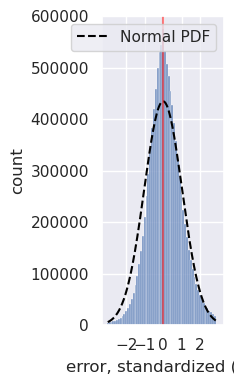

Processing combination: ('predicted_sd', 'slope', 'elevation')


/tmp/ipykernel_72042/2660494904.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2, bin3]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.07276766399343516
nmad: 0.8586083773345847
skewness: 0.5772943801914603
excess kurtosis: 0.08529935931470778


<Figure size 640x480 with 0 Axes>

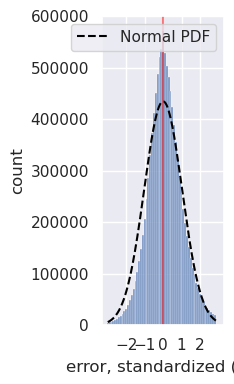

Processing combination: ('predicted_sd', 'slope', 'fcf')


/tmp/ipykernel_72042/2660494904.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2, bin3]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.07466374379590006
nmad: 0.8759896811703686
skewness: 0.6019235802580625
excess kurtosis: -0.2723482966680524


<Figure size 640x480 with 0 Axes>

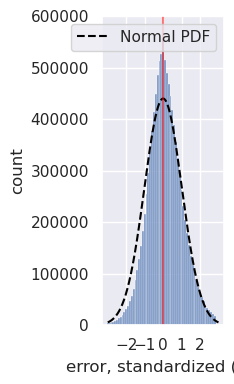

Processing combination: ('predicted_sd', 'aspect', 'elevation')


/tmp/ipykernel_72042/2660494904.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2, bin3]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.07283950269313483
nmad: 0.8616897182938039
skewness: 0.5905131576203995
excess kurtosis: 0.10288541520099193


<Figure size 640x480 with 0 Axes>

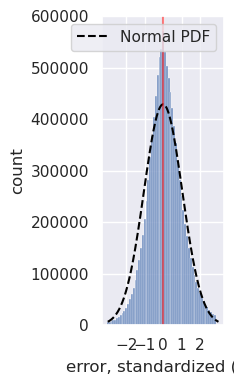

Processing combination: ('predicted_sd', 'aspect', 'fcf')


/tmp/ipykernel_72042/2660494904.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2, bin3]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.07521427659598598
nmad: 0.8855491059582371
skewness: 0.5956261496633387
excess kurtosis: -0.2682453559705076


<Figure size 640x480 with 0 Axes>

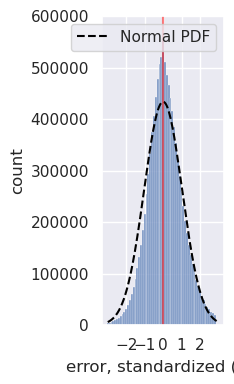

Processing combination: ('predicted_sd', 'elevation', 'fcf')


/tmp/ipykernel_72042/2660494904.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2, bin3]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.07695953156064314
nmad: 0.9018394936250492
skewness: 0.5092067093744367
excess kurtosis: -0.6856592573808538


<Figure size 640x480 with 0 Axes>

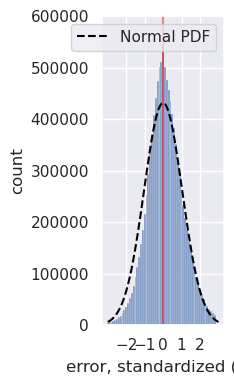

Processing combination: ('slope', 'aspect', 'elevation')


/tmp/ipykernel_72042/2660494904.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2, bin3]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.05651703463237481
nmad: 0.7536402879896289
skewness: 0.16892052172657657
excess kurtosis: 0.9763462280615944


<Figure size 640x480 with 0 Axes>

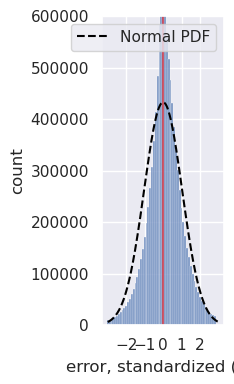

Processing combination: ('slope', 'aspect', 'fcf')


/tmp/ipykernel_72042/2660494904.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2, bin3]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.058265630740633026
nmad: 0.7887342114625184
skewness: 0.19045027102977566
excess kurtosis: 0.10060038461283893


<Figure size 640x480 with 0 Axes>

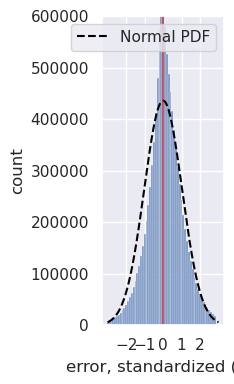

Processing combination: ('slope', 'elevation', 'fcf')


/tmp/ipykernel_72042/2660494904.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2, bin3]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.05942765363340437
nmad: 0.7966990106534279
skewness: 0.12957675980673272
excess kurtosis: -0.16017115599406084


<Figure size 640x480 with 0 Axes>

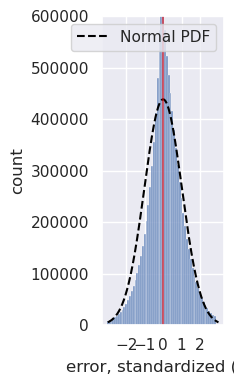

Processing combination: ('aspect', 'elevation', 'fcf')


/tmp/ipykernel_72042/2660494904.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2, bin3]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.06079460395402668
nmad: 0.8075609689672152
skewness: 0.1759553772392728
excess kurtosis: -0.14218664793721425


<Figure size 640x480 with 0 Axes>

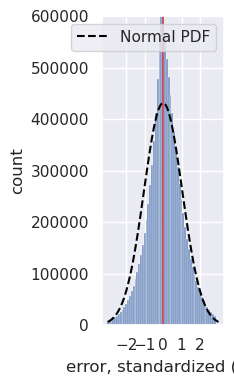

<Figure size 640x480 with 0 Axes>

In [324]:
# from scipy.stats import norm
# variables_to_test = ['predicted_sd', 'slope', 'aspect', 'elevation', 'fcf']
# run_all_triplet_combinations(df, variables_to_test, save_dir='error_plots', show_plots=True)

In [335]:
# def plot_standardized_error_distribution(df, variables, error_col='error', bin_suffix='_bins', min_std_threshold=0.01):
#     """
#     Plot standardized error distribution compared to a normal distribution.

#     Parameters:
#         df (pd.DataFrame): Input DataFrame containing error and binned variables.
#         variables (list of str): List of 3 variable names to use for heteroscedasticity modeling.
#         error_col (str): Name of the column containing error.
#         bin_suffix (str): Suffix used for binned versions of the variables.
#         min_std_threshold (float): Minimum standard deviation to enforce.

#     Returns:
#         None
#     """
#     assert len(variables) == 2, "Exactly three variables must be provided."

#     # Unpack variable names
#     var1, var2 = variables
#     bin1, bin2 = [v + bin_suffix for v in variables]

#     # Compute bin centers
#     for v, b in zip(variables, [bin1, bin2]):
#         df[f'{v}_center'] = df[b].apply(lambda x: (x.left + x.right) / 2)

#     # Group and compute std dev of error
#     grouped = df.groupby([bin1, bin2,]).agg({error_col: ['std', 'count']}).reset_index()
#     grouped.columns = [bin1, bin2, 'std', 'count']

#     # Bin centers
#     grouped[f'{var1}_center'] = [(i.left + i.right) / 2 for i in grouped[bin1]]
#     grouped[f'{var2}_center'] = [(i.left + i.right) / 2 for i in grouped[bin2]]

#     # Interpolation points and values
#     points = grouped[[f'{var1}_center', f'{var2}_center']].values
#     values = grouped['std'].values

#     # 3D grid over bin centers
#     grid_x, grid_y = np.meshgrid(
#         [(i.left + i.right) / 2 for i in df[bin1].cat.categories],
#         [(i.left + i.right) / 2 for i in df[bin2].cat.categories],
#         indexing='ij'
#     )

#     grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
#     interpolated_std = griddata(points, values, grid_points, method='linear')
#     interpolated_std = interpolated_std.reshape(grid_x.shape)

#     # Fill NaNs with nearest neighbor interpolation
#     if np.any(np.isnan(interpolated_std)):
#         nearest_values = griddata(points, values, grid_points, method='nearest').reshape(grid_x.shape)
#         interpolated_std[np.isnan(interpolated_std)] = nearest_values[np.isnan(interpolated_std)]

#     # Map interpolated std to the df using bin codes
#     df['interpolated_std'] = interpolated_std[
#         df[bin1].cat.codes.values,
#         df[bin2].cat.codes.values
#     ]

#     # Apply minimum threshold
#     df['interpolated_std'] = np.maximum(df['interpolated_std'], min_std_threshold)

#     # Standardize error
#     df['standardized_error'] = df[error_col] / df['interpolated_std']
#     df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['standardized_error'])
#     df = df[(df.standardized_error >= -8) & (df.standardized_error <= 8)]

#     print(f'median: {df.standardized_error.median()}')
#     print(f'nmad: {nmad(df.standardized_error)}')
#     print(f'skewness: {df.standardized_error.skew()}')
#     print(f'excess kurtosis: {df.standardized_error.kurtosis() - 3}')

#     # Plotting
#     f, ax = plt.subplots(figsize=(2.5, 4))
#     x = np.linspace(-3, 3, 500)
#     pdf = norm.pdf(x, loc=0, scale=np.std(df.standardized_error))
#     bin_width = 0.1
#     pdf_scaled = pdf * len(df.standardized_error) * bin_width

#     sns.histplot(df.standardized_error, ax=ax, bins=np.arange(-3, 3, 0.1)-0.05)
#     ax.plot(x, pdf_scaled, color='black', linestyle='--', label='Normal PDF')
#     ax.set_xlim(-3.3, 3.3)
#     ax.set_ylim(0, 0.6 * 1e6)
#     ax.set_xlabel('error, standardized (m)')
#     ax.set_ylabel('count')
#     ax.axvline(0, c='red', alpha=0.5)
#     ax.set_xticks([-2, -1, 0, 1, 2])
#     ax.legend()
#     plt.tight_layout()
#     plt.show()


In [332]:
# import itertools
# import os

# def run_all_double_combinations(
#     df, 
#     variable_list, 
#     error_col='error', 
#     bin_suffix='_bins',
#     save_dir=None,
#     show_plots=True
# ):
#     """
#     Run standardized error analysis for all combinations of three variables.

#     Parameters:
#         df (pd.DataFrame): Input DataFrame.
#         variable_list (list of str): Variables to consider.
#         error_col (str): Name of the error column.
#         bin_suffix (str): Suffix used for binned variable columns.
#         save_dir (str or None): If provided, saves plots to this directory.
#         show_plots (bool): Whether to display plots inline.

#     Returns:
#         None
#     """
#     from matplotlib import pyplot as plt

#     combos = list(itertools.combinations(variable_list, 2))

#     if save_dir:
#         os.makedirs(save_dir, exist_ok=True)

#     for combo in combos:
#         print(f"Processing combination: {combo}")
#         plt.clf()
#         plot_standardized_error_distribution(
#             df.copy(), 
#             list(combo), 
#             error_col=error_col, 
#             bin_suffix=bin_suffix
#         )
#         if save_dir:
#             filename = f"std_error_hist__{'_'.join(combo)}.png"
#             plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
#         if not show_plots:
#             plt.close()


Processing combination: ('predicted_sd', 'slope')


/tmp/ipykernel_72042/1370299769.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2,]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.06993547095562919
nmad: 0.8217858207126174
skewness: 0.7501114592971181
excess kurtosis: 1.1091286718073707


<Figure size 640x480 with 0 Axes>

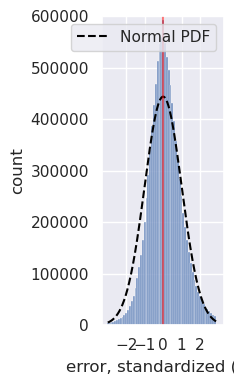

Processing combination: ('predicted_sd', 'aspect')


/tmp/ipykernel_72042/1370299769.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2,]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.06860534524714929
nmad: 0.8113130232477094
skewness: 0.7841232028885186
excess kurtosis: 1.2224510602433476


<Figure size 640x480 with 0 Axes>

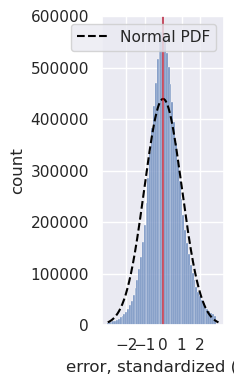

Processing combination: ('predicted_sd', 'elevation')


/tmp/ipykernel_72042/1370299769.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2,]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.0699928251082152
nmad: 0.8307059086628723
skewness: 0.6641710488052518
excess kurtosis: 0.38900229770795214


<Figure size 640x480 with 0 Axes>

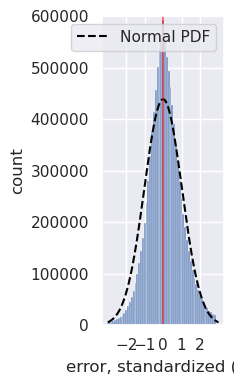

Processing combination: ('predicted_sd', 'fcf')


/tmp/ipykernel_72042/1370299769.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2,]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.07291011040464809
nmad: 0.8591063810925053
skewness: 0.6479715653517963
excess kurtosis: -0.13238679743046733


<Figure size 640x480 with 0 Axes>

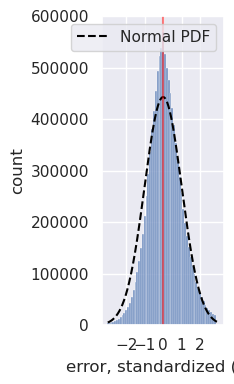

Processing combination: ('slope', 'aspect')


/tmp/ipykernel_72042/1370299769.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2,]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.05254194023696686
nmad: 0.7151459098019867
skewness: 0.27255709161272806
excess kurtosis: 2.6171612390519137


<Figure size 640x480 with 0 Axes>

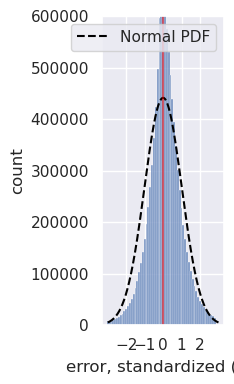

Processing combination: ('slope', 'elevation')


/tmp/ipykernel_72042/1370299769.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2,]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.054506564733576054
nmad: 0.7301741362685047
skewness: 0.16091660714428357
excess kurtosis: 1.2225619780418366


<Figure size 640x480 with 0 Axes>

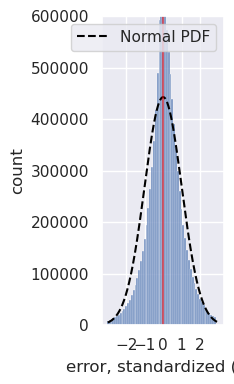

Processing combination: ('slope', 'fcf')


/tmp/ipykernel_72042/1370299769.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2,]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.05625476739173356
nmad: 0.7672182455347554
skewness: 0.19262907801169393
excess kurtosis: 0.2890255351180806


<Figure size 640x480 with 0 Axes>

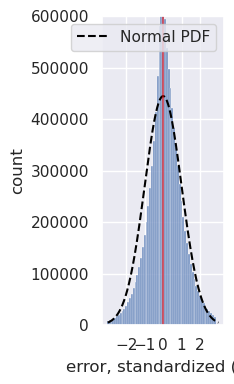

Processing combination: ('aspect', 'elevation')


/tmp/ipykernel_72042/1370299769.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2,]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.054833969151816674
nmad: 0.7283538607119867
skewness: 0.22088354245558803
excess kurtosis: 1.3852621412419985


<Figure size 640x480 with 0 Axes>

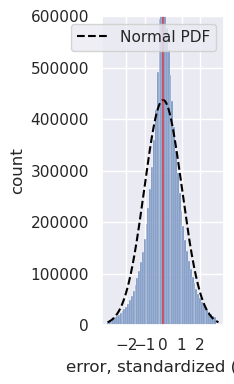

Processing combination: ('aspect', 'fcf')


/tmp/ipykernel_72042/1370299769.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2,]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.05736383689341204
nmad: 0.777485803390178
skewness: 0.2344213762106396
excess kurtosis: 0.25164683858493486


<Figure size 640x480 with 0 Axes>

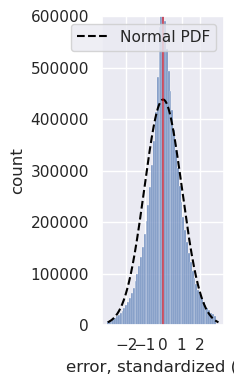

Processing combination: ('elevation', 'fcf')


/tmp/ipykernel_72042/1370299769.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([bin1, bin2,]).agg({error_col: ['std', 'count']}).reset_index()


median: 0.05862925657056467
nmad: 0.7827313944571636
skewness: 0.17762106946627587
excess kurtosis: 0.0815964600214083


<Figure size 640x480 with 0 Axes>

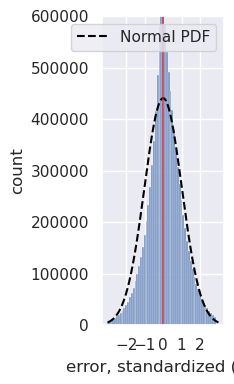

<Figure size 640x480 with 0 Axes>

In [336]:
# from scipy.stats import norm
# variables_to_test = ['predicted_sd', 'slope', 'aspect', 'elevation', 'fcf']
# run_all_double_combinations(df, variables_to_test, save_dir='error_plots', show_plots=True)

In [330]:
# def plot_standardized_error_distribution_4d(df, variables, error_col='error', bin_suffix='_bins', min_std_threshold=0.01):
#     """
#     Plot standardized error distribution compared to a normal distribution using 4D bin interpolation.

#     Parameters:
#         df (pd.DataFrame): Input DataFrame.
#         variables (list of str): List of 4 variable names to use for heteroscedasticity modeling.
#         error_col (str): Name of the column containing error.
#         bin_suffix (str): Suffix used for binned versions of the variables.
#         min_std_threshold (float): Minimum standard deviation to enforce.

#     Returns:
#         None
#     """
#     assert len(variables) == 4, "Exactly four variables must be provided."

#     bin_vars = [v + bin_suffix for v in variables]

#     # Compute bin centers
#     for v, b in zip(variables, bin_vars):
#         df[f'{v}_center'] = df[b].apply(lambda x: (x.left + x.right) / 2)

#     # Group and compute std dev of error
#     grouped = df.groupby(bin_vars).agg({error_col: ['std', 'count']}).reset_index()
#     grouped.columns = bin_vars + ['std', 'count']

#     # Add bin centers to grouped data
#     for v, b in zip(variables, bin_vars):
#         grouped[f'{v}_center'] = [(i.left + i.right) / 2 for i in grouped[b]]

#     # Interpolation points and values
#     points = grouped[[f'{v}_center' for v in variables]].values
#     values = grouped['std'].values

#     # 4D grid over bin centers
#     bin_grids = [np.array([(i.left + i.right) / 2 for i in df[b].cat.categories]) for b in bin_vars]
#     grid_mesh = np.meshgrid(*bin_grids, indexing='ij')
#     grid_points = np.stack([g.ravel() for g in grid_mesh], axis=-1)

#     interpolated_std = griddata(points, values, grid_points, method='linear')
#     interpolated_std = interpolated_std.reshape([len(g) for g in bin_grids])

#     # Fill NaNs with nearest interpolation
#     if np.any(np.isnan(interpolated_std)):
#         nearest_values = griddata(points, values, grid_points, method='nearest').reshape(interpolated_std.shape)
#         interpolated_std[np.isnan(interpolated_std)] = nearest_values[np.isnan(interpolated_std)]

#     # Map interpolated std to the df using bin codes
#     df['interpolated_std'] = interpolated_std[
#         df[bin_vars[0]].cat.codes.values,
#         df[bin_vars[1]].cat.codes.values,
#         df[bin_vars[2]].cat.codes.values,
#         df[bin_vars[3]].cat.codes.values
#     ]

#     # Apply minimum std threshold
#     df['interpolated_std'] = np.maximum(df['interpolated_std'], min_std_threshold)

#     # Standardize error
#     df['standardized_error'] = df[error_col] / df['interpolated_std']
#     df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['standardized_error'])
#     df = df[(df.standardized_error >= -8) & (df.standardized_error <= 8)]

#     print(f'median: {df.standardized_error.median()}')
#     print(f'nmad: {nmad(df.standardized_error)}')
#     print(f'skewness: {df.standardized_error.skew()}')
#     print(f'excess kurtosis: {df.standardized_error.kurtosis() - 3}')

#     # Plotting
#     f, ax = plt.subplots(figsize=(2.5, 4))
#     x = np.linspace(-3, 3, 500)
#     pdf = norm.pdf(x, loc=0, scale=np.std(df.standardized_error))
#     bin_width = 0.1
#     pdf_scaled = pdf * len(df.standardized_error) * bin_width

#     sns.histplot(df.standardized_error, ax=ax, bins=np.arange(-3, 3, 0.1)-0.05)
#     ax.plot(x, pdf_scaled, color='black', linestyle='--', label='Normal PDF')
#     ax.set_xlim(-3.3, 3.3)
#     ax.set_ylim(0, 0.6 * 1e6)
#     ax.set_xlabel('error, standardized (m)')
#     ax.set_ylabel('count')
#     ax.axvline(0, c='red', alpha=0.5)
#     ax.set_xticks([-2, -1, 0, 1, 2])
#     ax.legend()
#     plt.tight_layout()
#     plt.show()

# def run_all_quadruplet_combinations(
#     df, 
#     variable_list, 
#     error_col='error', 
#     bin_suffix='_bins',
#     save_dir=None,
#     show_plots=True
# ):
#     """
#     Run standardized error analysis for all combinations of four variables.

#     Parameters:
#         df (pd.DataFrame): Input DataFrame.
#         variable_list (list of str): Variables to consider.
#         error_col (str): Name of the error column.
#         bin_suffix (str): Suffix used for binned variable columns.
#         save_dir (str or None): If provided, saves plots to this directory.
#         show_plots (bool): Whether to display plots inline.

#     Returns:
#         None
#     """
#     from matplotlib import pyplot as plt
#     import itertools
#     import os

#     combos = list(itertools.combinations(variable_list, 4))

#     if save_dir:
#         os.makedirs(save_dir, exist_ok=True)

#     for combo in combos:
#         print(f"Processing combination: {combo}")
#         plt.clf()
#         plot_standardized_error_distribution_4d(
#             df.copy(), 
#             list(combo), 
#             error_col=error_col, 
#             bin_suffix=bin_suffix
#         )
#         if save_dir:
#             filename = f"std_error_hist__{'_'.join(combo)}.png"
#             plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
#         if not show_plots:
#             plt.close()


Processing combination: ('predicted_sd', 'slope', 'aspect', 'elevation')


/tmp/ipykernel_72042/498298642.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(bin_vars).agg({error_col: ['std', 'count']}).reset_index()


median: 0.07630148492974727
nmad: 0.8999056260669803
skewness: 0.4742232762880172
excess kurtosis: -0.44471757720855143


<Figure size 640x480 with 0 Axes>

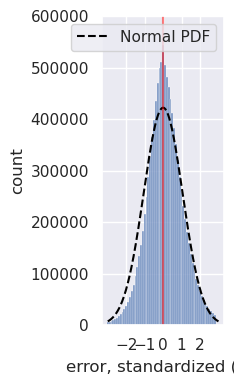

Processing combination: ('predicted_sd', 'slope', 'aspect', 'fcf')


/tmp/ipykernel_72042/498298642.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(bin_vars).agg({error_col: ['std', 'count']}).reset_index()


median: 0.07777888110351108
nmad: 0.9132760123179653
skewness: 0.5068393868289016
excess kurtosis: -0.8022293785420147


<Figure size 640x480 with 0 Axes>

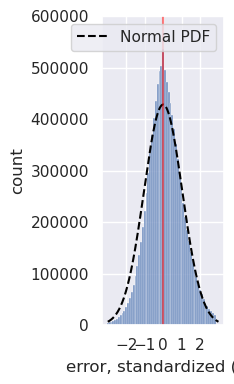

Processing combination: ('predicted_sd', 'slope', 'elevation', 'fcf')


/tmp/ipykernel_72042/498298642.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(bin_vars).agg({error_col: ['std', 'count']}).reset_index()


median: 0.07941559894166017
nmad: 0.9297738752432222
skewness: 0.4012471205266999
excess kurtosis: -1.09360804855887


<Figure size 640x480 with 0 Axes>

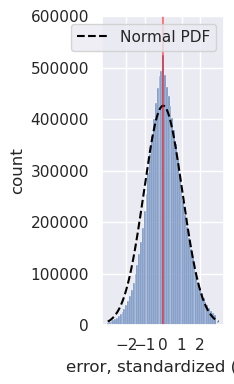

Processing combination: ('predicted_sd', 'aspect', 'elevation', 'fcf')


/tmp/ipykernel_72042/498298642.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(bin_vars).agg({error_col: ['std', 'count']}).reset_index()


median: 0.08072179187936268
nmad: 0.9472178039884789
skewness: 0.4108767164165894
excess kurtosis: -1.119694835238175


<Figure size 640x480 with 0 Axes>

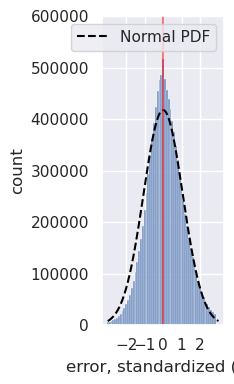

Processing combination: ('slope', 'aspect', 'elevation', 'fcf')


/tmp/ipykernel_72042/498298642.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(bin_vars).agg({error_col: ['std', 'count']}).reset_index()


median: 0.0626618669023328
nmad: 0.8336374306643811
skewness: 0.1216422349558709
excess kurtosis: -0.6335270051238884


<Figure size 640x480 with 0 Axes>

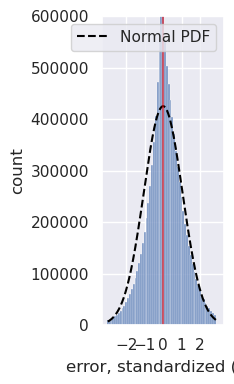

In [331]:
# variables_to_test = ['predicted_sd', 'slope', 'aspect', 'elevation', 'fcf']
# run_all_quadruplet_combinations(df, variables_to_test, save_dir='error_plots_4d', show_plots=False)

In [348]:
print(f'median: {df.standardized_error.median()}')
print(f'nmad: {nmad(df.standardized_error)}')
print(f'skewness: {df.standardized_error.skew()}')
print(f'kurtosis: {df.standardized_error.kurtosis()}')

median: 0.08099800680736238
nmad: 0.9264605091498522
skewness: 0.5107837437525569
kurtosis: 3.7291364393879842


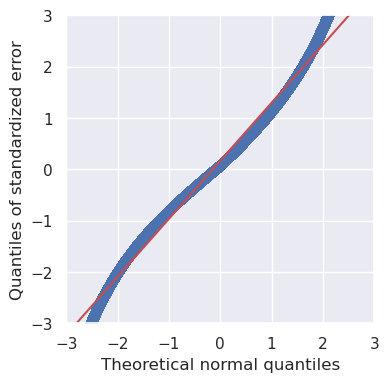

In [367]:
import scipy.stats as stats

# Create a Q-Q plot
f, ax = plt.subplots(figsize=(4, 4))
stats.probplot(df['standardized_error'], dist="norm", plot=ax)
ax.plot([-4, 4], [4, 4], color='k', linestyle='-', linewidth=1, alpha=0.3)
#stats.probplot(df['error'], dist="norm", plot=ax)
ax.set_title('')
ax.set_xlabel('Theoretical normal quantiles')
ax.set_ylabel('Quantiles of standardized error')
ax.set_ylim(-3, 3)
ax.set_xlim(-3, 3)
ax.set_aspect('equal')

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_standardized_errorQ-Q.png', dpi=400, bbox_inches='tight')

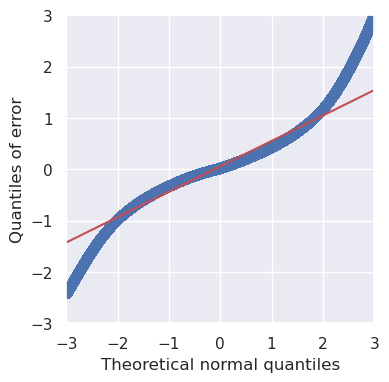

In [366]:
# Create a Q-Q plot
f, ax = plt.subplots(figsize=(4, 4))
stats.probplot(df['error'], dist="norm", plot=ax)
ax.plot([-4, 4], [4, 4], color='k', linestyle='-', linewidth=1, alpha=0.3)
ax.set_title('')
ax.set_xlabel('Theoretical normal quantiles')
ax.set_ylabel('Quantiles of error')
ax.set_ylim(-3, 3)
ax.set_xlim(-3, 3)
ax.set_aspect('equal')

f.savefig('../../../figs/ResDepth_lr0.000457_weightdecay0.000105_epochs62_mintestloss0.00091_errorQ-Q.png', dpi=400, bbox_inches='tight')

## create uncertainty maps

In [12]:
test_path_list.sort()
for i, path in enumerate(test_path_list):
    print(i, path)

0 /mnt/working/brencher/repos/deep-snow/data/test_tiles/ASO_50M_SD_BigThompsonLittleThompson_20230521_clean_tile101.nc
1 /mnt/working/brencher/repos/deep-snow/data/test_tiles/ASO_50M_SD_BigThompsonLittleThompson_20230521_clean_tile87.nc
2 /mnt/working/brencher/repos/deep-snow/data/test_tiles/ASO_50M_SD_BoulderCreek_20230509_clean_tile101.nc
3 /mnt/working/brencher/repos/deep-snow/data/test_tiles/ASO_50M_SD_BoulderCreek_20230509_clean_tile87.nc
4 /mnt/working/brencher/repos/deep-snow/data/test_tiles/ASO_50M_SD_Carson_20220311_clean_tile53.nc
5 /mnt/working/brencher/repos/deep-snow/data/test_tiles/ASO_50M_SD_Carson_20220311_clean_tile82.nc
6 /mnt/working/brencher/repos/deep-snow/data/test_tiles/ASO_50M_SD_Carson_20220406_clean_tile53.nc
7 /mnt/working/brencher/repos/deep-snow/data/test_tiles/ASO_50M_SD_Carson_20220406_clean_tile82.nc
8 /mnt/working/brencher/repos/deep-snow/data/test_tiles/ASO_50M_SD_Carson_20220513_clean_tile53.nc
9 /mnt/working/brencher/repos/deep-snow/data/test_tiles/A

In [116]:
# # make predictions
# index = 166
# ds = prep_dataset(test_path_list[index])
# ds = ds.isel(x=slice(0, 640), y=slice(0, 640))
# ds = apply_model(ds, model, input_channels)
# ds['all_gaps'] = ds['aso_gap_map'] + ds['rtc_gap_map'] + ds['s2_gap_map']
# ds2 = ds.where(ds.all_gaps == 0, drop=True)

In [121]:
# make predictions
index = 87
ds = prep_dataset(test_path_list[index])
ds = ds.isel(x=slice(0, 640), y=slice(0, 640))
ds = apply_model(ds, model, input_channels)
ds['all_gaps'] = ds['aso_gap_map'] + ds['rtc_gap_map'] + ds['s2_gap_map']
ds = ds.where(ds.all_gaps == 0, drop=True)
fn = test_path_list[index].split('/')[-1].split('.')[0]

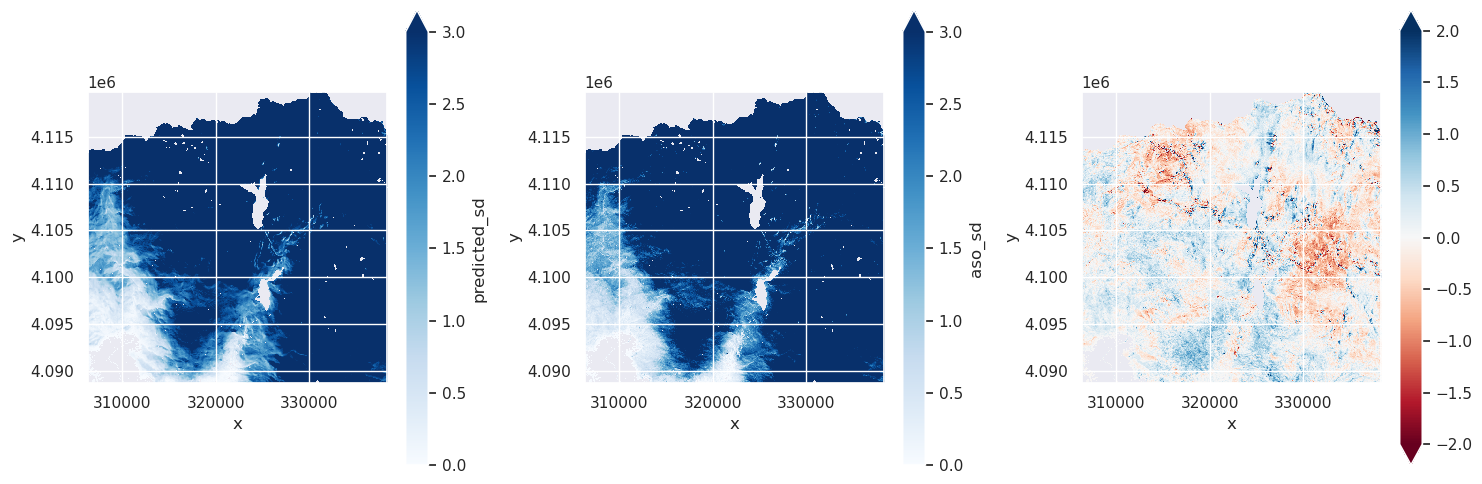

In [110]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ds.predicted_sd.plot.imshow(ax=ax[0], cmap='Blues', vmin=0, vmax=3, interpolation='none')
ds.aso_sd.plot.imshow(ax=ax[1], cmap='Blues', vmin=0, vmax=3, interpolation='none')
(ds.aso_sd - ds.predicted_sd).plot.imshow(ax=ax[2], cmap='RdBu', vmin=-2, vmax=2, interpolation='none')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')
ax[0].set_title('')
ax[1].set_title('')
ax[2].set_title('')
f.tight_layout()
f.savefig(f'../../../figs/{fn}_colorbars.png', dpi=300, bbox_inches='tight')

In [58]:
np.arange(-2, 2, 0.1)-0.05

array([-2.05, -1.95, -1.85, -1.75, -1.65, -1.55, -1.45, -1.35, -1.25,
       -1.15, -1.05, -0.95, -0.85, -0.75, -0.65, -0.55, -0.45, -0.35,
       -0.25, -0.15, -0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,
        0.65,  0.75,  0.85,  0.95,  1.05,  1.15,  1.25,  1.35,  1.45,
        1.55,  1.65,  1.75,  1.85])

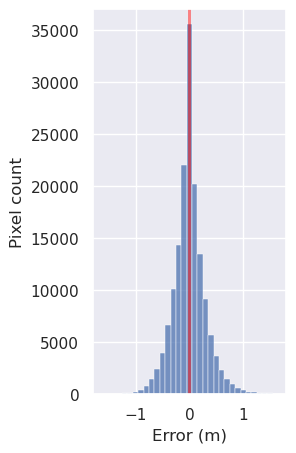

In [123]:
##### sns.set_theme()
f, ax = plt.subplots(figsize=(2.5, 5))
sns.histplot((ds.aso_sd.where(ds.aso_sd > 0) - ds.predicted_sd.where(ds.aso_sd > 0)).values.ravel(), bins=np.arange(-2, 2, 0.1)-0.05)
ax.axvline(0, c='red', alpha=0.5, linewidth=2)
ax.set_xlim(-1.8, 1.8)
ax.set_ylim(0, 37000)
#ax.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
ax.set_ylabel('Pixel count')
ax.set_xlabel('Error (m)')
f.savefig(f'../../../figs/{fn}_error_hist.png', dpi=300, bbox_inches='tight')

In [351]:
fn = test_path_list[index].split('/')[-1].split('.')[0]
ds.aso_sd.rio.to_raster(f'test_predictions/{fn}_aso_sd.tif', compress='LZW')
ds.predicted_sd.rio.to_raster(f'test_predictions/{fn}_predicted_sd.tif', compress='LZW')

In [81]:
# apply bias correction
# Flatten the predicted_sd values to 1D
predicted_sd_flat = ds['predicted_sd'].values.flatten()
# Predict the bias for the 1D array
predicted_bias_flat = predicted_interpolator(predicted_sd_flat)
# Reshape the predicted bias back to the original shape
predicted_bias_reshaped = predicted_bias_flat.reshape(ds['predicted_sd'].shape)
# Add the bias-corrected prediction to the dataset
ds['bias_predicted'] = (('y', 'x'), predicted_bias_reshaped)
ds['predicted_sd_corrected'] = ds['predicted_sd'] + ds['bias_predicted']

In [82]:
def bin_data(data, bins):
    binned_data = np.digitize(data, bins) - 1
    # Handle NaN values separately
    binned_data = np.where(binned_data > 9, np.nan, binned_data)
    return binned_data
    
# Adjust the bin edges to be open-ended
predicted_sd_bins = [-np.inf] + [bin.left for bin in df['predicted_sd_corrected_bins'].cat.categories][1:10] + [np.inf]
elevation_bins = [-np.inf] + [bin.left for bin in df['elevation_bins'].cat.categories][1:10] + [np.inf]
slope_bins = [-np.inf] + [bin.left for bin in df['slope_bins'].cat.categories][1:10] + [np.inf]
fcf_bins = [-np.inf] + [bin.left for bin in df['fcf_bins'].cat.categories][1:10] + [np.inf]

# Apply the binning function
ds['predicted_sd_corrected_bins'] = xr.apply_ufunc(bin_data, ds['predicted_sd_corrected'], kwargs={'bins': predicted_sd_bins}, dask='allowed')
ds['elevation_bins'] = xr.apply_ufunc(bin_data, ds['elevation'], kwargs={'bins': elevation_bins}, dask='allowed')
ds['slope_bins'] = xr.apply_ufunc(bin_data, ds['slope'], kwargs={'bins': slope_bins}, dask='allowed')
ds['fcf_bins'] = xr.apply_ufunc(bin_data, ds['fcf'], kwargs={'bins': fcf_bins}, dask='allowed')

In [83]:
def map_nmad(psd_bins, elev_bins, slope_bins, fcf_bins, nmad_array):
    valid = ~np.isnan(psd_bins) & ~np.isnan(elev_bins) & ~np.isnan(slope_bins) & ~np.isnan(fcf_bins)
    result = np.full(psd_bins.shape, np.nan)
    result[valid] = nmad_array[psd_bins[valid].astype(int), elev_bins[valid].astype(int), slope_bins[valid].astype(int), fcf_bins[valid].astype(int)]
    return result

# Apply the NMAD mapping function to the dataset
ds['precision_map'] = xr.apply_ufunc(map_nmad, 
                                     ds['predicted_sd_corrected_bins'], 
                                     ds['elevation_bins'], 
                                     ds['slope_bins'], 
                                     ds['fcf_bins'], 
                                     kwargs={'nmad_array': interpolated_nmad}, 
                                     dask='parallelized', 
                                     output_dtypes=[float])

In [84]:
## standardize error
ds['error'] = ds['predicted_sd_corrected'] - ds['aso_sd']
ds['error_standardized'] = ds['error']/ds['precision_map']

## remove outliers 
ds['error_standardized'] = ds['error_standardized'].where(ds['error_standardized'] < 50)
ds['error_standardized'] = ds['error_standardized'].where(ds['error_standardized'] > -50)

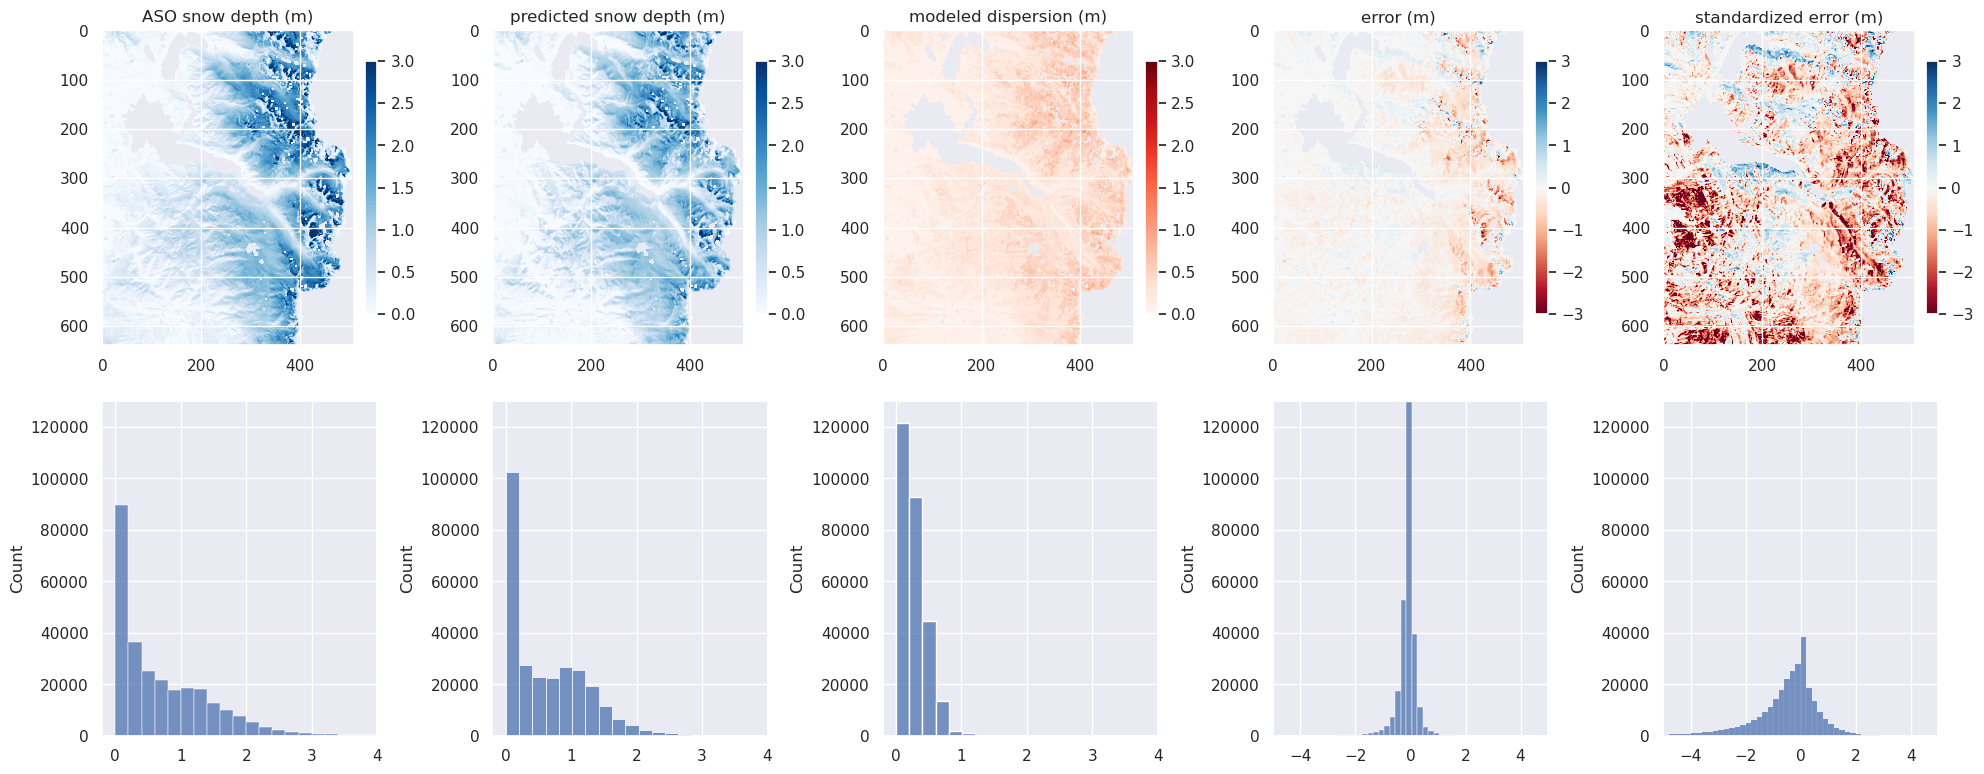

In [85]:
f, ax = plt.subplots(2, 5, figsize=(20, 8))
im0 = ax[0, 0].imshow(ds.aso_sd, cmap='Blues', vmin=0, vmax=3)
ax[0, 0].set_aspect('equal')
ax[0, 0].set_title('ASO snow depth (m)')
f.colorbar(im0, ax=ax[0, 0], fraction=0.046, pad=0.04)

im1 = ax[0, 1].imshow(ds.predicted_sd_corrected, cmap='Blues', vmin=0, vmax=3)
ax[0, 1].set_aspect('equal')
ax[0, 1].set_title('predicted snow depth (m)')
f.colorbar(im1, ax=ax[0, 1], fraction=0.046, pad=0.04)

im2 = ax[0, 2].imshow(ds.precision_map, cmap='Reds', vmin=0, vmax=3)
ax[0, 2].set_aspect('equal')
ax[0, 2].set_title('modeled dispersion (m)')
f.colorbar(im2, ax=ax[0, 2], fraction=0.046, pad=0.04)

im3 = ax[0, 3].imshow(ds['error'], cmap='RdBu', vmin=-3, vmax=3)
ax[0, 3].set_aspect('equal')
ax[0, 3].set_title('error (m)')
f.colorbar(im3, ax=ax[0, 3], fraction=0.046, pad=0.04)

im4 = ax[0, 4].imshow(ds.error_standardized, cmap='RdBu', vmin=-3, vmax=3)
ax[0, 4].set_aspect('equal')
ax[0, 4].set_title('standardized error (m)')
f.colorbar(im4, ax=ax[0, 4], fraction=0.046, pad=0.04)

sns.histplot(ds.aso_sd.values.ravel(), ax=ax[1, 0], binwidth=0.2)
ax[1, 0].set_xlim(-0.2, 4)
ax[1, 0].set_ylim(0, 130000)
#ax[1, 0].set_title('ASO snow depth')
sns.histplot(ds.predicted_sd_corrected.values.ravel(), ax=ax[1, 1], binwidth=0.2)
ax[1, 1].set_xlim(-0.2, 4)
ax[1, 1].set_ylim(0, 130000)
#ax[1, 1].set_title('predicted snow depth')
sns.histplot(ds.precision_map.values.ravel(), ax=ax[1, 2], binwidth=0.2)
ax[1, 2].set_xlim(-0.2, 4)
ax[1, 2].set_ylim(0, 130000)
sns.histplot(ds['error'].values.ravel(), ax=ax[1, 3], binwidth=0.2)
ax[1, 3].set_xlim(-5, 5)
ax[1, 3].set_ylim(0, 130000)
#ax[1, 2].set_title('error')
sns.histplot(ds['error_standardized'].values.ravel(), ax=ax[1, 4], binwidth=0.2)
ax[1, 4].set_xlim(-5, 5)
ax[1, 4].set_ylim(0, 130000)
#ax[1, 3].set_title('standardized error')
f.tight_layout()
f.savefig(f'figs/{test_path_list[index].split("/")[-1].split(".")[0]}_error.png', dpi=400)

In [95]:
# import pickle

# # Save the bias interpolator
# with open(f'../../../data/deep-snow_data/{model_path.split("/")[-1]}_bias_interpolator.pkl', 'wb') as f:
#     pickle.dump(predicted_interpolator, f)

# # Save the interpolated NMAD array
# np.save(f'../../../data/deep-snow_data/{model_path.split("/")[-1]}_interpolated_nmad.npy', interpolated_nmad)

# # Save the bin edges
# bins = {
#     'predicted_sd_bins': predicted_sd_bins,
#     'elevation_bins': elevation_bins,
#     'slope_bins': slope_bins,
#     'fcf_bins': fcf_bins
# }

# with open(f'../../../data/deep-snow_data/{model_path.split("/")[-1]}_bin_edges.pkl', 'wb') as f:
#     pickle.dump(bins, f)

## spatial structure of random error

In [70]:
import xdem

In [285]:
# Sample empirical variogram
df_vgm = xdem.spatialstats.sample_empirical_variogram(values=ds.error_standardized.values, gsd=50, subsample=2000, n_variograms=10, random_state=42)

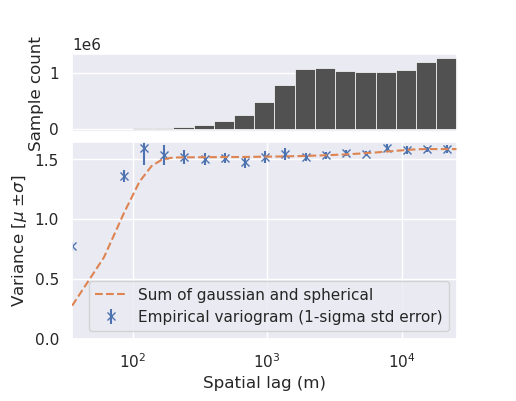

In [286]:
# Fit the sum of a gaussian and spherical model
func_sum_vgm, params_variogram_model = xdem.spatialstats.fit_sum_model_variogram(
    list_models=["Gaussian", "Spherical"], empirical_variogram=df_vgm
)
# Plot empirical and modelled variogram
xdem.spatialstats.plot_variogram(df_vgm, [func_sum_vgm], ["Sum of gaussian and spherical"], xscale="log")

In [287]:
area = (ds.predicted_sd_corrected.count()*50*50).item()

In [288]:
params_variogram_model

,model,range,psill
0,gaussian,158.144461,1.514620
0,spherical,15081.881236,0.070527


In [289]:
# Calculate the area-averaged uncertainty with these models
neff = xdem.spatialstats.number_effective_samples(area=area, params_variogram_model=params_variogram_model)

In [290]:
# total snow depth
total_depth_predicted = ds.predicted_sd_corrected.mean()*area
total_depth_aso = ds.aso_sd.mean()*area

In [291]:
# total uncertainty
total_uncertainty = (ds.precision_map.mean()/np.sqrt(neff))*area

In [292]:
# percent error: 
(total_uncertainty/total_depth_predicted).item()*100

3.633331250532158

In [293]:
# true percent error:
((total_depth_aso - total_depth_predicted)/total_depth_aso).item()*100

-21.963751045745823